# Import Dependensi

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import keras_tuner as kt
import tensorflow as tf
import matplotlib as mpl
from numpy import hstack
from numpy import array
from datetime import datetime, timedelta
from tensorflow import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import GRU, Dense, RepeatVector, TimeDistributed, Dropout, BatchNormalization, Activation
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

Matplotlib created a temporary cache directory at /var/folders/86/7gxks06s07xch2nsjg8bfzhh0000gn/T/matplotlib-85oba_u7 because the default path (/Users/ingwerludwig/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Load Dataset Baru

In [2]:
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
excel_path = os.path.join(parent_dir, 'Fix Data_Model Welang.xlsx')

In [3]:
merge_df = pd.read_excel(excel_path)
merge_df.drop('Unnamed: 0',axis=1,inplace=True)
merge_df['DateTime'] = pd.to_datetime(merge_df['DateTime'])
merge_df.sort_values(by='DateTime',ascending=True,inplace=True)
merge_df

DateTime   RC   RL     LP     LD
0    2022-09-20 20:00:00  0.0  0.0  0.107  0.315
1    2022-09-20 21:00:00  0.0  0.0  0.108  0.307
2    2022-09-20 22:00:00  0.0  0.0  0.106  0.297
3    2022-09-20 23:00:00  0.0  0.0  0.108  0.293
4    2022-09-21 00:00:00  0.0  0.0  0.111  0.292
...                  ...  ...  ...    ...    ...
8628 2023-09-15 08:00:00  0.0  0.0  0.070  0.213
8629 2023-09-15 09:00:00  0.0  0.0  0.080  0.228
8630 2023-09-15 10:00:00  0.0  0.0  0.089  0.237
8631 2023-09-15 11:00:00  0.0  0.0  0.096  0.245
8632 2023-09-15 12:00:00  0.0  0.0  0.099  0.251

[8633 rows x 5 columns]

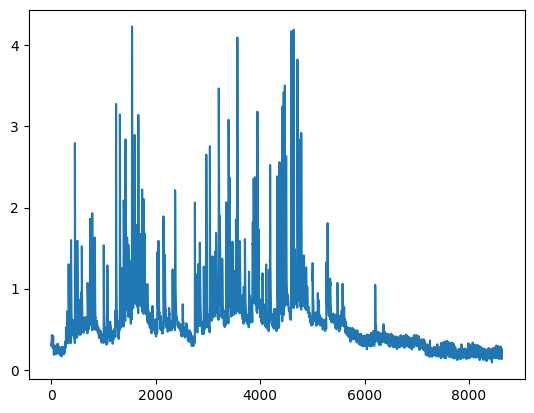

In [4]:
plt.plot(merge_df['LD'])

# Cek data dengan nilai 0 selain di Curah Hujan

In [5]:
columns_to_replace = [
    'LP',
    'LD'
]

mask = (merge_df[columns_to_replace] == 0).any(axis=1)
filtered_rows = merge_df[mask]
filtered_rows.sort_values(by='DateTime')

DateTime   RC   RL   LP     LD
7866 2023-08-14 14:00:00  0.0  0.0  0.0  0.179
7884 2023-08-15 08:00:00  0.0  0.0  0.0  0.196
7885 2023-08-15 09:00:00  0.0  0.0  0.0  0.201
7886 2023-08-15 10:00:00  0.0  0.0  0.0  0.202
7887 2023-08-15 11:00:00  0.0  0.0  0.0  0.199
7888 2023-08-15 12:00:00  0.0  0.0  0.0  0.197
7889 2023-08-15 13:00:00  0.0  0.0  0.0  0.193
7890 2023-08-15 14:00:00  0.0  0.0  0.0  0.189
7907 2023-08-16 07:00:00  0.0  0.0  0.0  0.180
7908 2023-08-16 08:00:00  0.0  0.0  0.0  0.177
7909 2023-08-16 09:00:00  0.0  0.0  0.0  0.171
7910 2023-08-16 10:00:00  0.0  0.0  0.0  0.167
7911 2023-08-16 11:00:00  0.0  0.0  0.0  0.174
7912 2023-08-16 12:00:00  0.0  0.0  0.0  0.193
7913 2023-08-16 13:00:00  0.0  0.0  0.0  0.220
7914 2023-08-16 14:00:00  0.0  0.0  0.0  0.237
7915 2023-08-16 15:00:00  0.0  0.0  0.0  0.251
7931 2023-08-17 07:00:00  0.0  0.0  0.0  0.171
7932 2023-08-17 08:00:00  0.0  0.0  0.0  0.167
7933 2023-08-17 09:00:00  0.0  0.0  0.0  0.166
7934 2023-08-17 10:00:00  0.0  0.0  0.0  0.160
7935 2023-08-17 11:00:00  0.0  0.0  0.0  0.172
7936 2023-08-17 12:00:00  0.0  0.0  0.0  0.193
7937 2023-08-17 13:00:00  0.0  0.0  0.0  0.239
7938 2023-08-17 14:00:00  0.0  0.0  0.0  0.239
7939 2023-08-17 15:00:00  0.0  0.0  0.0  0.235
7980 2023-08-19 08:00:00  0.0  0.0  0.0  0.266
7981 2023-08-19 09:00:00  0.0  0.0  0.0  0.293
7982 2023-08-19 10:00:00  0.0  0.0  0.0  0.299
7983 2023-08-19 11:00:00  0.0  0.0  0.0  0.287
7984 2023-08-19 12:00:00  0.0  0.0  0.0  0.326
7985 2023-08-19 13:00:00  0.0  0.0  0.0  0.313
7986 2023-08-19 14:00:00  0.0  0.0  0.0  0.304
7987 2023-08-19 15:00:00  0.0  0.0  0.0  0.297
8481 2023-09-09 05:00:00  0.0  0.0  0.0  0.181

# Visualisasi Tren

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
copy_df_2 = merge_df.iloc[48:144,:]
copy_df_2 = copy_df_2.set_index('DateTime')
copy_df_2.index.freq = 'H'

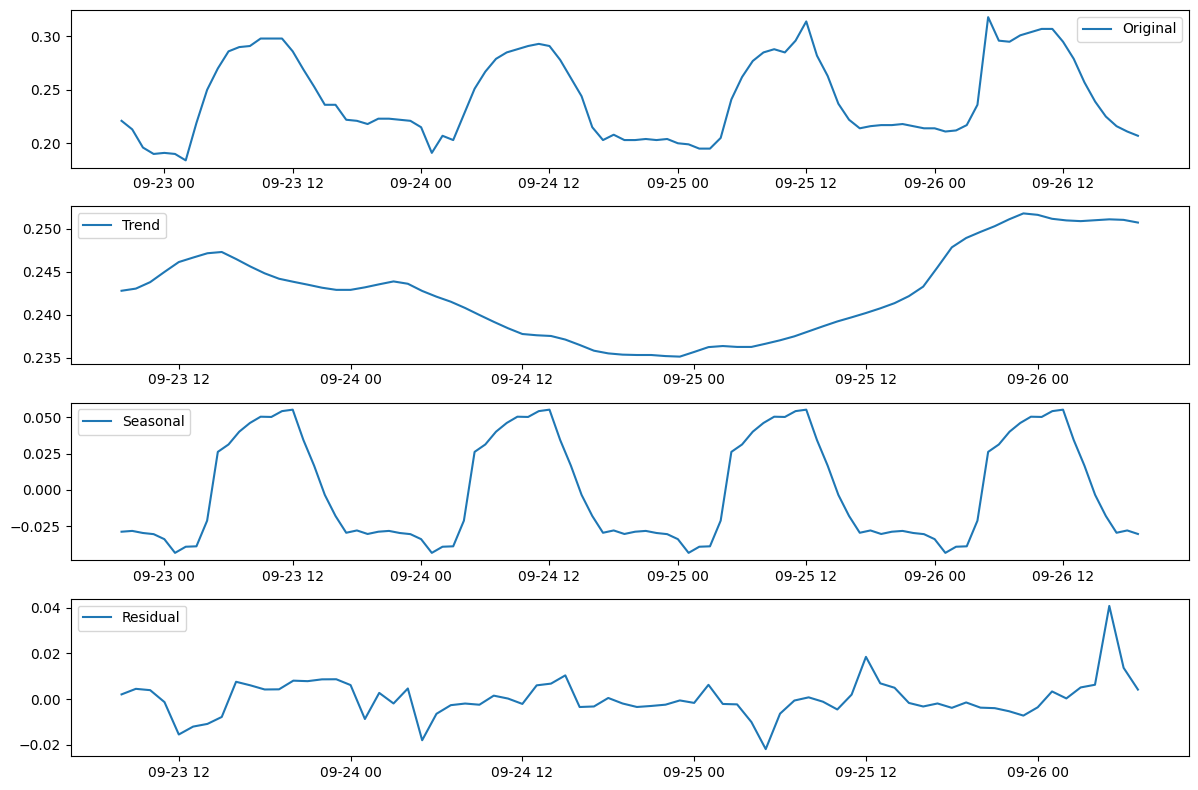

In [7]:
results = seasonal_decompose(copy_df_2['LD'])

plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(copy_df_2['LD'], label='Original')
plt.legend()

plt.subplot(412)
plt.plot(results.trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(results.seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(results.resid, label='Residual')
plt.legend()

plt.tight_layout()
plt.show()


# Ekstrak Fitur Datetime untuk digunakan dalam TimeSeries Forecasting

In [8]:
test = merge_df.iloc[0:1,0]
test

0   2022-09-20 20:00:00
Name: DateTime, dtype: datetime64[ns]

In [9]:
print(test.dt.hour)

0    20
Name: DateTime, dtype: int32


In [10]:
merge_df['hour_at'] = merge_df['DateTime'].dt.hour
merge_df

DateTime   RC   RL     LP     LD  hour_at
0    2022-09-20 20:00:00  0.0  0.0  0.107  0.315       20
1    2022-09-20 21:00:00  0.0  0.0  0.108  0.307       21
2    2022-09-20 22:00:00  0.0  0.0  0.106  0.297       22
3    2022-09-20 23:00:00  0.0  0.0  0.108  0.293       23
4    2022-09-21 00:00:00  0.0  0.0  0.111  0.292        0
...                  ...  ...  ...    ...    ...      ...
8628 2023-09-15 08:00:00  0.0  0.0  0.070  0.213        8
8629 2023-09-15 09:00:00  0.0  0.0  0.080  0.228        9
8630 2023-09-15 10:00:00  0.0  0.0  0.089  0.237       10
8631 2023-09-15 11:00:00  0.0  0.0  0.096  0.245       11
8632 2023-09-15 12:00:00  0.0  0.0  0.099  0.251       12

[8633 rows x 6 columns]

# Visualisasi Jam Terhadap Rerata Muka Air Dhompo

Text(0, 0.5, 'Rerata Tinggi Muka Air Dhompo')

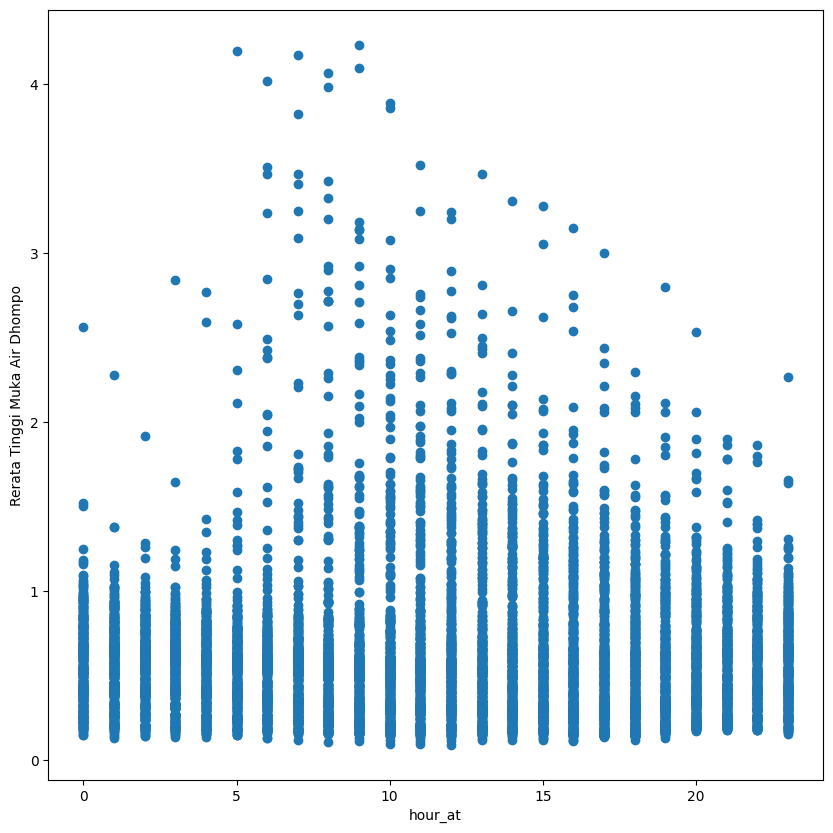

In [11]:
plt.figure(figsize=(10,10))
plt.scatter(x='hour_at',y='LD',data=merge_df)
plt.xlabel('hour_at')
plt.ylabel('Rerata Tinggi Muka Air Dhompo')

# Mutivariat Sekuens untuk Input dan Output LSTM

In [12]:
def split_sequences_sliding(sequences, n_steps_in, n_steps_out, step=1):
    X, y = list(), list()
    for i in range(0, len(sequences) - n_steps_in - n_steps_out + 1, step):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [13]:
merge_df.drop(['DateTime','hour_at'],axis=1,inplace=True)
merge_df

RC   RL     LP     LD
0     0.0  0.0  0.107  0.315
1     0.0  0.0  0.108  0.307
2     0.0  0.0  0.106  0.297
3     0.0  0.0  0.108  0.293
4     0.0  0.0  0.111  0.292
...   ...  ...    ...    ...
8628  0.0  0.0  0.070  0.213
8629  0.0  0.0  0.080  0.228
8630  0.0  0.0  0.089  0.237
8631  0.0  0.0  0.096  0.245
8632  0.0  0.0  0.099  0.251

[8633 rows x 4 columns]

# Apply Sliding Window

In [14]:
n_steps_in, n_steps_out = 3, 5
train_percent, validation_percent = 0.7, 0.2

x_data, y_data = split_sequences_sliding(merge_df.to_numpy(), n_steps_in, n_steps_out)

# Train Test Split

In [15]:
from sklearn.model_selection import train_test_split
x_for_training_and_val, x_test, y_for_training_and_val, y_test = train_test_split(x_data, y_data, test_size=1-train_percent-validation_percent)
x_train, x_validation, y_train, y_validation = train_test_split(x_for_training_and_val, y_for_training_and_val, test_size=0.23)

In [16]:
y_test = y_test[:, :, -1].reshape(-1, n_steps_out)
y_train = y_train[:, :, -1].reshape(-1, n_steps_out)
y_validation = y_validation[:, :, -1].reshape(-1, n_steps_out)

In [17]:
print('Data for train:', x_train.shape, y_train.shape)
print('Total days for train:', x_train.shape[0] / 24)
print('\nData for validation:', x_validation.shape, y_validation.shape)
print('Total days for validation:', x_validation.shape[0]  / 24)
print('\nData for test:', x_test.shape, y_test.shape)
print('Total days for test:', x_test.shape[0]  / 24)

Data for train: (5977, 3, 4) (5977, 5)
Total days for train: 249.04166666666666

Data for validation: (1786, 3, 4) (1786, 5)
Total days for validation: 74.41666666666667

Data for test: (863, 3, 4) (863, 5)
Total days for test: 35.958333333333336


# Scaling

In [18]:
from sklearn.preprocessing import StandardScaler

x_train_reshaped = x_train.reshape(-1, x_train.shape[-1])
x_validation_reshaped = x_validation.reshape(-1, x_validation.shape[-1])
x_test_reshaped = x_test.reshape(-1, x_test.shape[-1])

x_scaler = StandardScaler()
x_scaler.fit(x_train_reshaped)

x_train_scaled = x_scaler.transform(x_train_reshaped).reshape(x_train.shape)
x_validation_scaled = x_scaler.transform(x_validation_reshaped).reshape(x_validation.shape)
x_test_scaled = x_scaler.transform(x_test_reshaped).reshape(x_test.shape)

y_train_reshaped = y_train
y_validation_reshaped = y_validation
y_test_reshaped = y_test

y_scaler = StandardScaler()
y_scaler.fit(y_train_reshaped)

y_train_scaled = y_scaler.transform(y_train_reshaped)
y_validation_scaled = y_scaler.transform(y_validation_reshaped)
y_test_scaled = y_scaler.transform(y_test_reshaped)

In [19]:
print('Data for train:', x_train_scaled.shape, y_train_scaled.shape)
print('Total days for train:', x_train_scaled.shape[0] / 24)
print('\nData for validation:', x_validation_scaled.shape, y_validation_scaled.shape)
print('Total days for validation:', x_validation_scaled.shape[0] / 24)
print('\nData for test:', x_test_scaled.shape, y_test_scaled.shape)
print('Total days for test:', x_test_scaled.shape[0] / 24)

Data for train: (5977, 3, 4) (5977, 5)
Total days for train: 249.04166666666666

Data for validation: (1786, 3, 4) (1786, 5)
Total days for validation: 74.41666666666667

Data for test: (863, 3, 4) (863, 5)
Total days for test: 35.958333333333336


In [20]:
print('Total features:', 4)
print('Total train data:', x_train_scaled.shape)
print('Total validation data:', x_validation_scaled.shape)
print('Total test data:', x_test_scaled.shape)

Total features: 4
Total train data: (5977, 3, 4)
Total validation data: (1786, 3, 4)
Total test data: (863, 3, 4)


In [21]:
print('Total features:', 4)
print('Total train data:', y_train_scaled.shape)
print('Total validation data:', y_validation_scaled.shape)
print('Total test data:', y_test_scaled.shape)

Total features: 4
Total train data: (5977, 5)
Total validation data: (1786, 5)
Total test data: (863, 5)


# Training Model

In [22]:
# model = Sequential()

# model.add(GRU(300, input_shape=(n_steps_in, 4)))
# model.add(RepeatVector(n_steps_out))
# model.add(GRU(300, return_sequences=True))
# model.add(Activation('relu'))
# model.add(TimeDistributed(Dense(1)))

# model.summary()

# Model Tuning

In [23]:
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [25]:
from keras.metrics import RootMeanSquaredError
from keras.losses import Huber
from tensorflow.keras.optimizers.legacy import SGD

def build_model(hp):
    model = Sequential()

    hp_gru_units = hp.Int('gru_units', min_value=50, max_value=500, step=50)
    model.add(GRU(units=hp_gru_units, input_shape=(n_steps_in, 4)))

    model.add(RepeatVector(n_steps_out))

    hp_gru_units_layer2 = hp.Int('gru_units_layer2', min_value=50, max_value=500, step=50)
    return_sequences = hp.Boolean('return_sequences', default=True)
    model.add(GRU(units=hp_gru_units_layer2, return_sequences=return_sequences))

    hp_activation = hp.Choice('activation', values=['relu', 'tanh'], default='relu')
    model.add(Activation(hp_activation))

    hp_optimizer = hp.Choice('optimizer', values=['adam', 'sgd'], default='adam')
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log', default=1e-3)
    optimizer = keras.optimizers.legacy.Adam(learning_rate=learning_rate) if hp_optimizer == 'adam' else SGD(learning_rate=learning_rate)
    
    hp_loss_function = hp.Choice('loss_function', values=['rmse', 'huber'], default='rmse')
    
    if hp_loss_function == 'rmse':
        loss_function = root_mean_squared_error
    elif hp_loss_function == 'huber':
        delta = hp.Float('huber_delta', min_value=0.1, max_value=2.0, default=1.0)
        loss_function = Huber(delta=delta)
        
    model.add(TimeDistributed(Dense(1)))

    model.compile(optimizer=optimizer,
                  loss=loss_function,
                  metrics=RootMeanSquaredError())

    return model


In [27]:
from kerastuner.tuners import RandomSearch
from kerastuner import Objective

tuner = RandomSearch(
    build_model,
    objective=Objective("val_root_mean_squared_error", direction="min"),
    max_trials=10,
    directory='keras-tuning',
    project_name='dhompo_gru_tuning'
)

tuner.search(x_train_scaled, y_train_scaled, epochs=100, validation_data=(x_validation_scaled, y_validation_scaled))

Trial 10 Complete [00h 01m 52s]
val_root_mean_squared_error: 0.6610462665557861

Best val_root_mean_squared_error So Far: 0.5179109573364258
Total elapsed time: 00h 14m 19s


In [28]:
best_model = tuner.get_best_models(num_models=1)[0]

In [29]:
best_model.evaluate(x_test_scaled, y_test_scaled)

27/27 [==============================] - 0s 2ms/step - loss: 0.0799 - root_mean_squared_error: 0.5026


[0.0798712819814682, 0.502610981464386]

In [26]:
# model = Sequential()

# model.add(GRU(300, input_shape=(n_steps_in, 4)))
# model.add(RepeatVector(n_steps_out))
# model.add(GRU(300, return_sequences=True))
# model.add(Activation('relu'))
# model.add(TimeDistributed(Dense(1)))

# model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 300)               275400    
                                                                 
 repeat_vector_1 (RepeatVec  (None, 5, 300)            0         
 tor)                                                            
                                                                 
 gru_3 (GRU)                 (None, 5, 300)            541800    
                                                                 
 activation_1 (Activation)   (None, 5, 300)            0         
                                                                 
 time_distributed_1 (TimeDi  (None, 5, 1)              301       
 stributed)                                                      
                                                                 
Total params: 817501 (3.12 MB)
Trainable params: 81750

# Fit Model

In [27]:
# epoch = 50
# model.compile(optimizer='adam', loss=root_mean_squared_error, metrics=root_mean_squared_error)
# model.fit(x_train_scaled, y_train_scaled, epochs=epoch, batch_size=32,validation_data=(x_validation_scaled, y_validation_scaled), verbose=1)

Epoch 1/50
187/187 [==============================] - 4s 15ms/step - loss: 0.5317 - root_mean_squared_error: 0.5321 - val_loss: 0.5162 - val_root_mean_squared_error: 0.5153
Epoch 2/50
187/187 [==============================] - 3s 15ms/step - loss: 0.5005 - root_mean_squared_error: 0.5008 - val_loss: 0.5054 - val_root_mean_squared_error: 0.5045
Epoch 3/50
187/187 [==============================] - 3s 16ms/step - loss: 0.4913 - root_mean_squared_error: 0.4921 - val_loss: 0.5058 - val_root_mean_squared_error: 0.5049
Epoch 4/50
187/187 [==============================] - 3s 14ms/step - loss: 0.4811 - root_mean_squared_error: 0.4809 - val_loss: 0.4979 - val_root_mean_squared_error: 0.4970
Epoch 5/50
187/187 [==============================] - 3s 16ms/step - loss: 0.4883 - root_mean_squared_error: 0.4884 - val_loss: 0.4954 - val_root_mean_squared_error: 0.4945
Epoch 6/50
187/187 [==============================] - 3s 15ms/step - loss: 0.4791 - root_mean_squared_error: 0.4788 - val_loss: 0.5153 

# Test Model

In [30]:
predictions = y_scaler.inverse_transform(best_model.predict_generator(x_test_scaled).reshape(-1,n_steps_out))
print(predictions.shape)

print(y_test.shape)

(863, 5)
(863, 5)


In [28]:
# predictions = y_scaler.inverse_transform(model.predict_generator(x_test_scaled).reshape(-1,n_steps_out))
# print(predictions.shape)

# print(y_test.shape)

(863, 5)
(863, 5)


In [31]:
predictions_train = y_scaler.inverse_transform(best_model.predict_generator(x_train_scaled).reshape(-1,n_steps_out))
print(predictions_train.shape)
print(y_train.shape)

(5977, 5)
(5977, 5)


In [29]:
# predictions_train = y_scaler.inverse_transform(model.predict_generator(x_train_scaled).reshape(-1,n_steps_out))
# print(predictions_train.shape)
# print(y_train.shape)

(5977, 5)
(5977, 5)


# Bentuk Prediksi ke Dataframe

In [32]:
real = y_test
real_train = y_train
predictions = pd.DataFrame(predictions)
predictions_for_train = pd.DataFrame(predictions_train)
real = pd.DataFrame(real)
real_train = pd.DataFrame(real_train)
print(predictions.shape)
print(real.shape)
print(predictions_for_train.shape)
print(real_train.shape)

(863, 5)
(863, 5)
(5977, 5)
(5977, 5)


# Plot Model Test Dataset

In [33]:
real[0]

0      0.332
1      0.746
2      0.431
3      0.361
4      1.585
       ...  
858    0.277
859    0.917
860    0.675
861    0.415
862    0.399
Name: 0, Length: 863, dtype: float64

In [34]:
predictions[0]

0      0.330406
1      0.777694
2      0.420854
3      0.372265
4      1.769313
         ...   
858    0.275865
859    0.941182
860    0.634978
861    0.415982
862    0.389656
Name: 0, Length: 863, dtype: float32

In [35]:
real[1]

0      0.333
1      0.805
2      0.424
3      0.353
4      1.317
       ...  
858    0.266
859    0.876
860    0.673
861    0.423
862    0.393
Name: 1, Length: 863, dtype: float64

In [36]:
predictions[1]

0      0.327124
1      0.791821
2      0.416943
3      0.381327
4      1.515971
         ...   
858    0.270583
859    0.928295
860    0.652925
861    0.404296
862    0.381115
Name: 1, Length: 863, dtype: float32

In [37]:
real[2]

0      0.330
1      0.816
2      0.418
3      0.356
4      1.147
       ...  
858    0.252
859    0.846
860    0.677
861    0.422
862    0.386
Name: 2, Length: 863, dtype: float64

In [38]:
predictions[2]

0      0.325064
1      0.809984
2      0.416804
3      0.395270
4      1.391952
         ...   
858    0.266995
859    0.876386
860    0.675649
861    0.393974
862    0.375218
Name: 2, Length: 863, dtype: float32

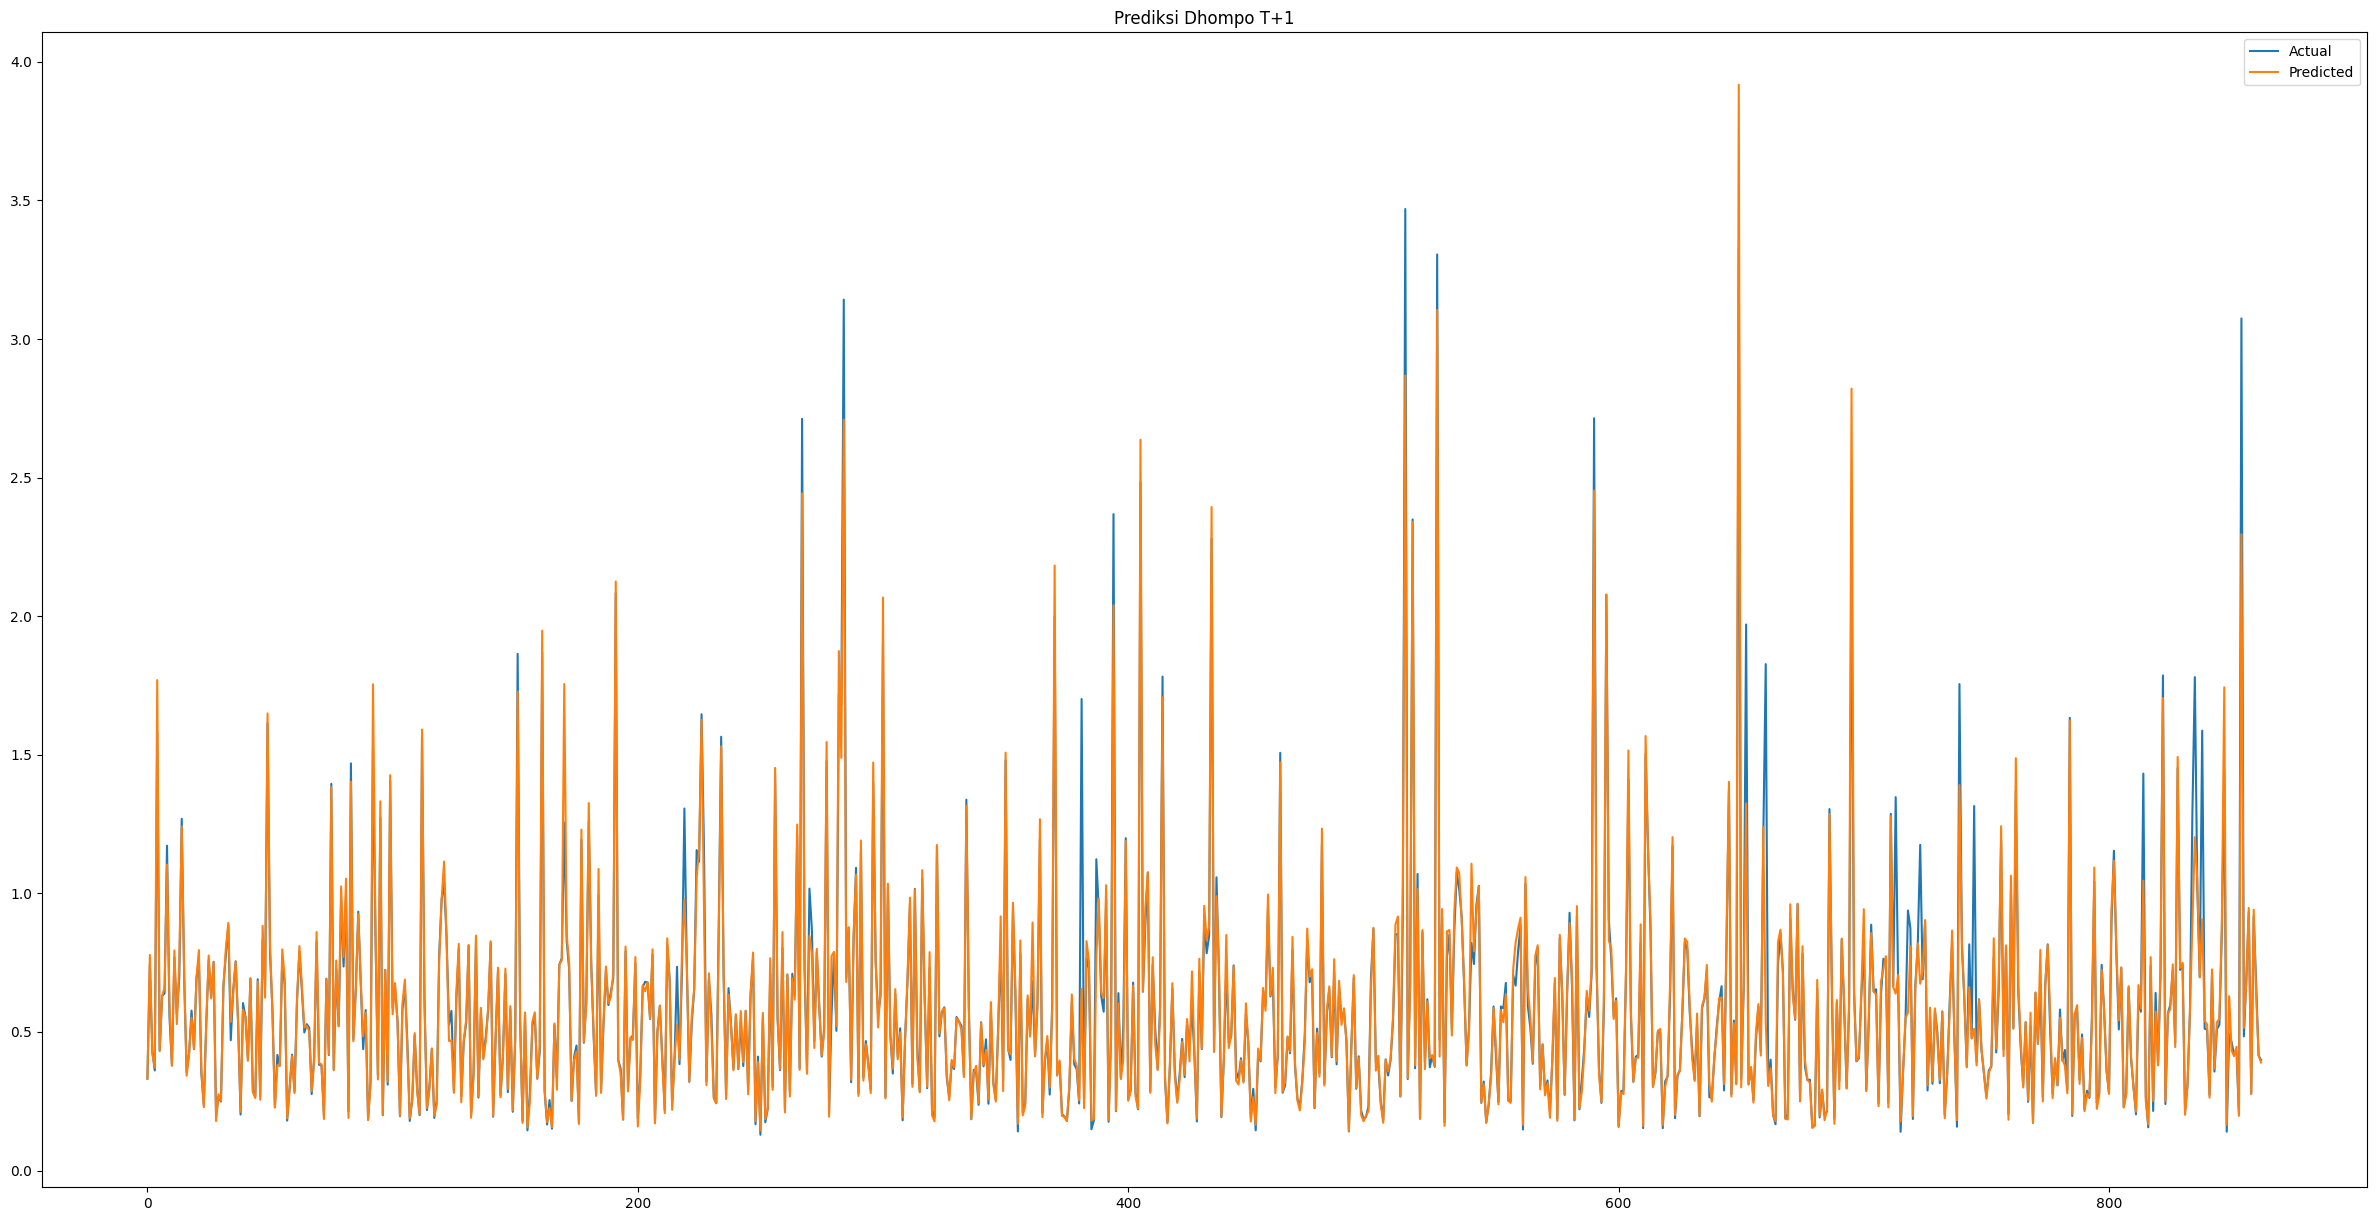

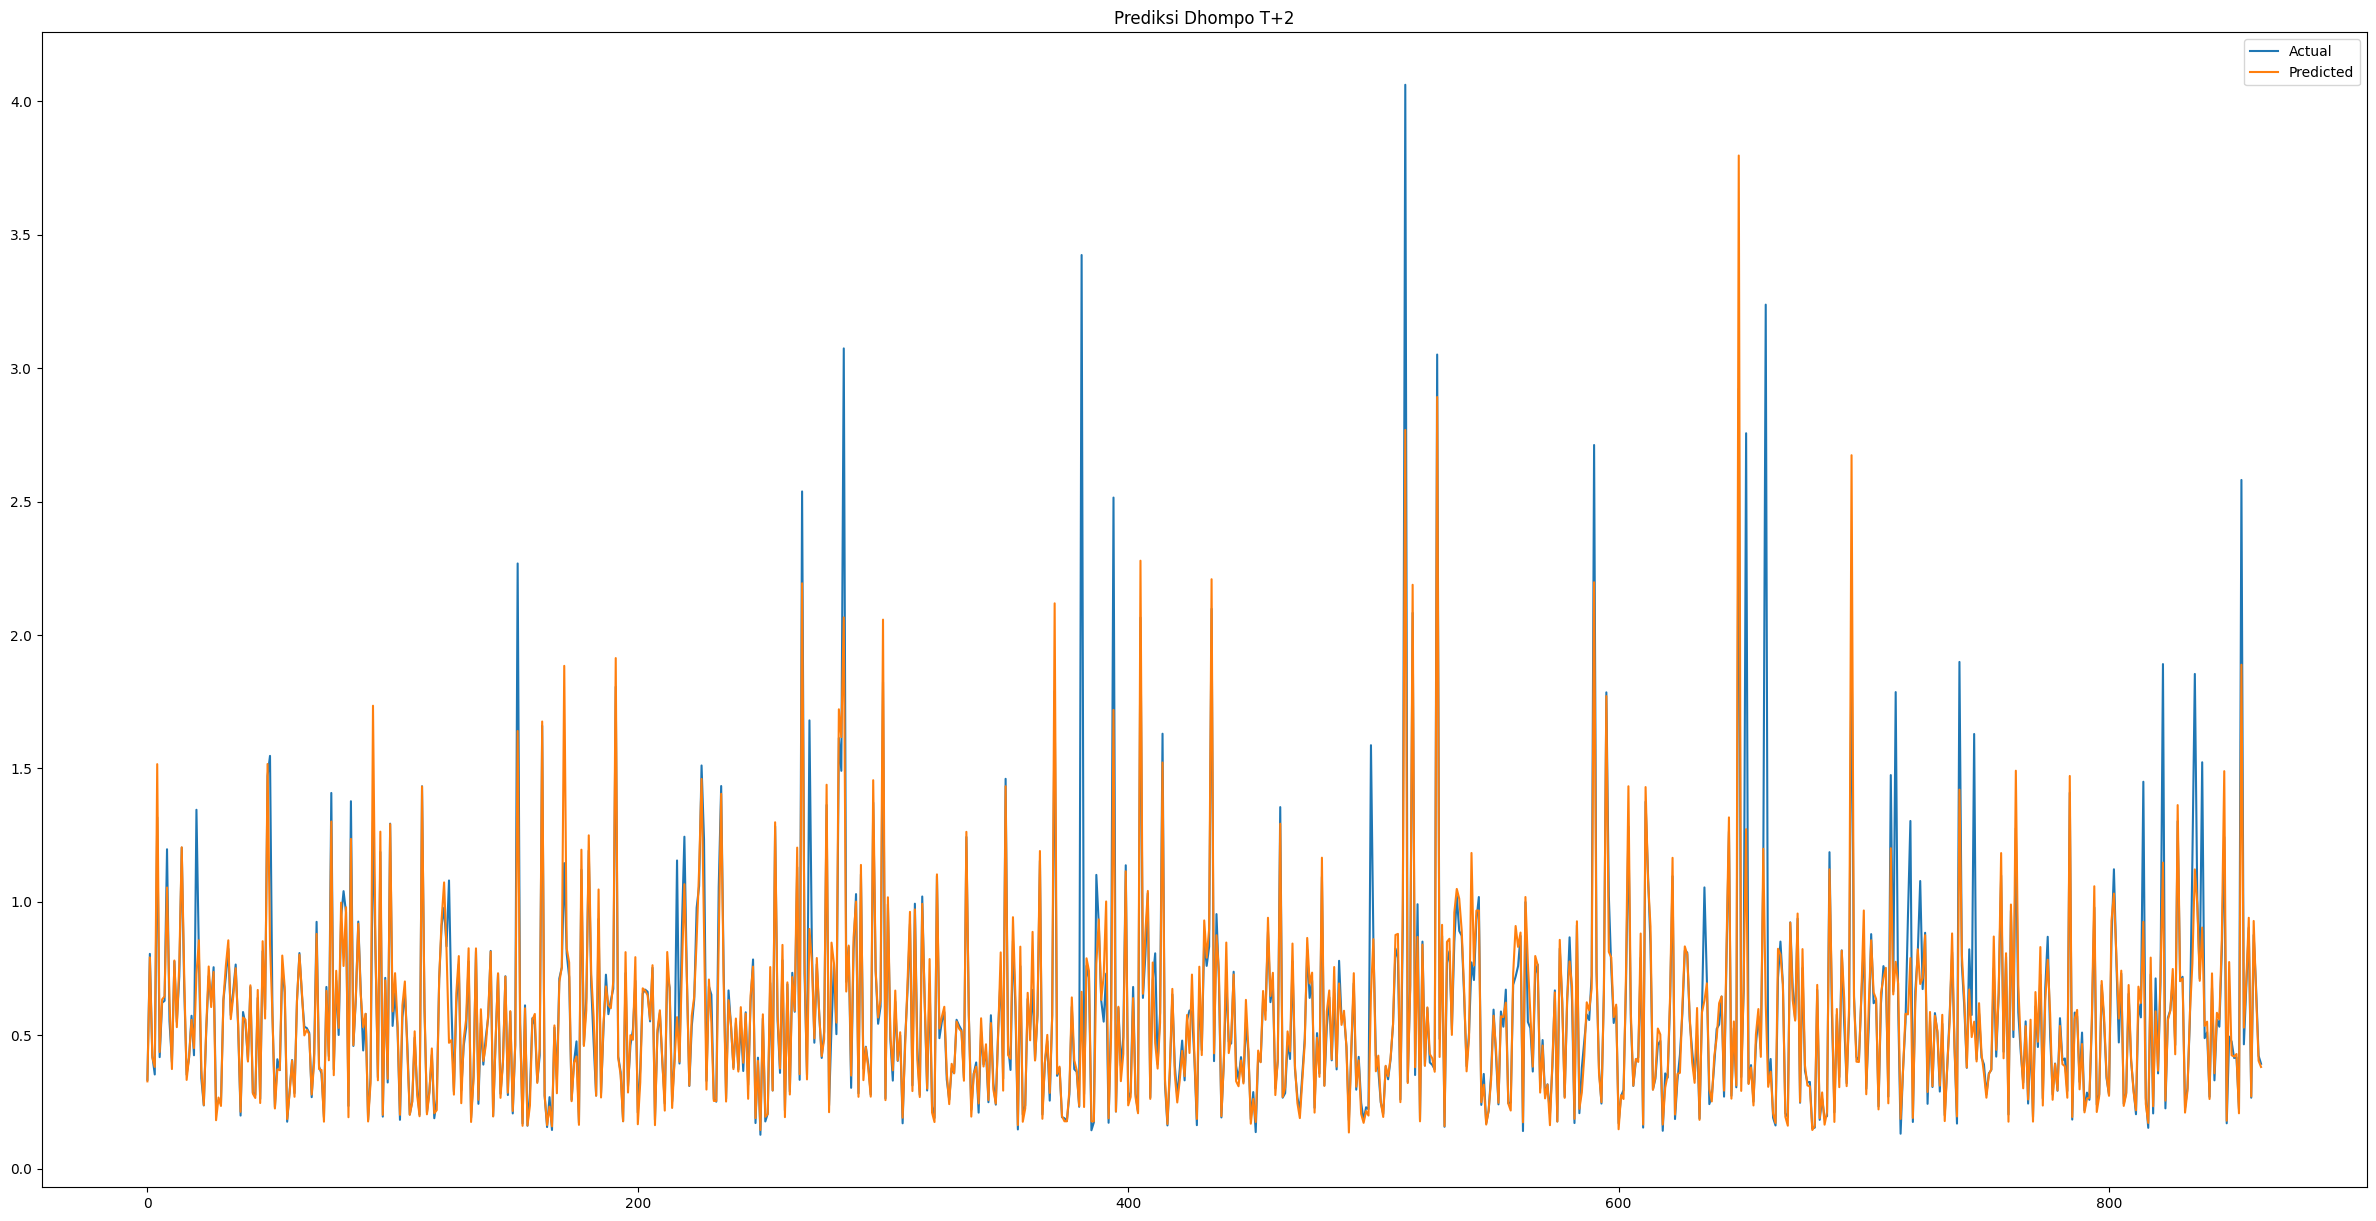

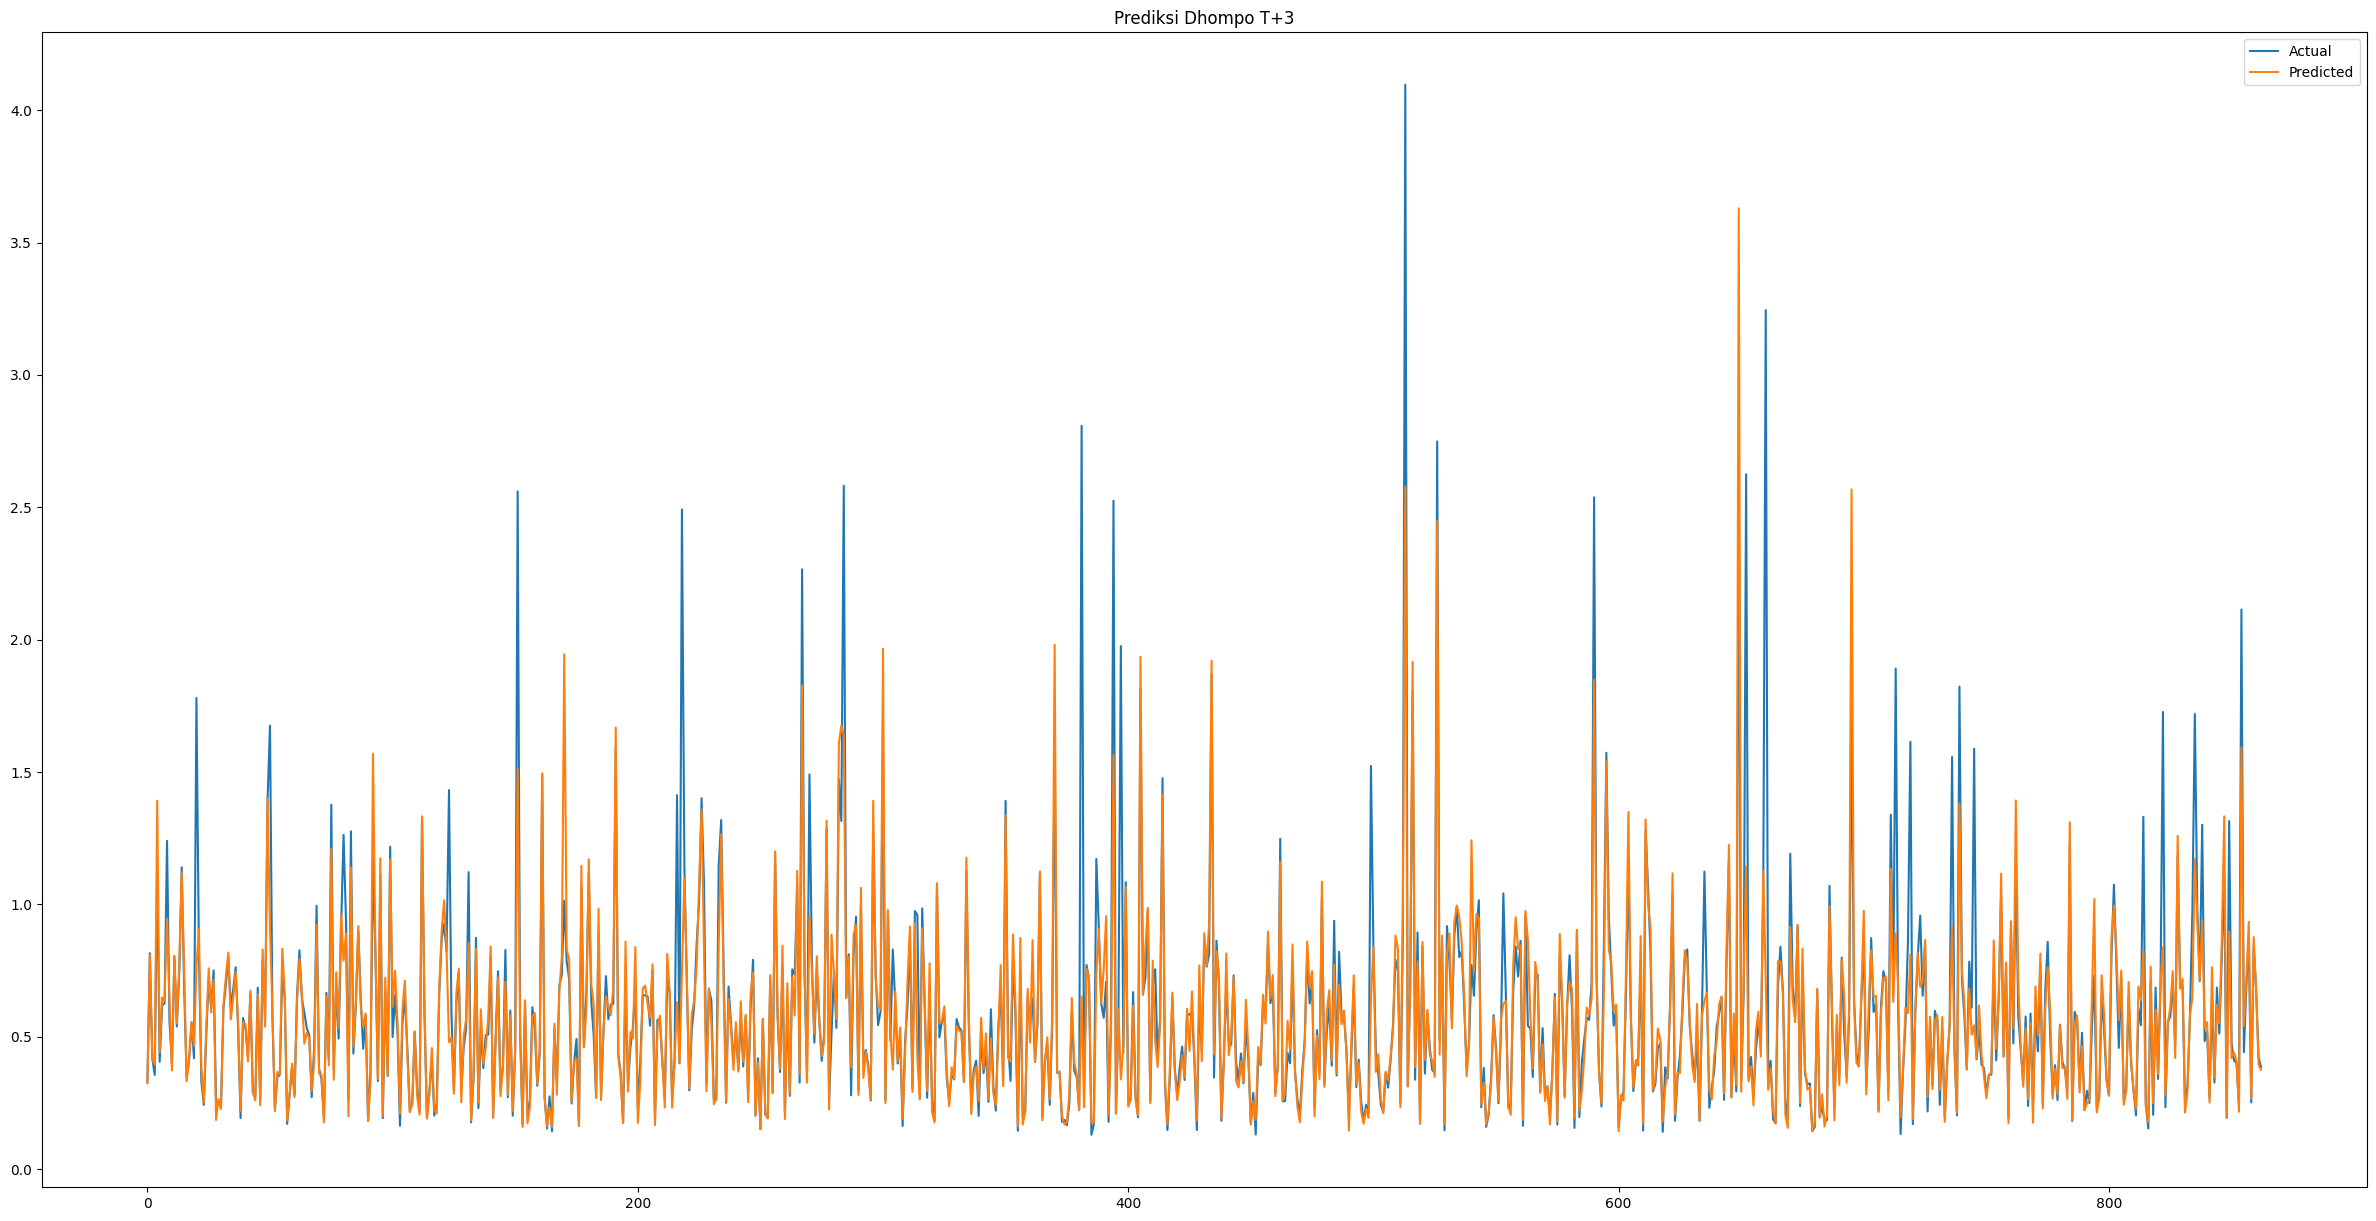

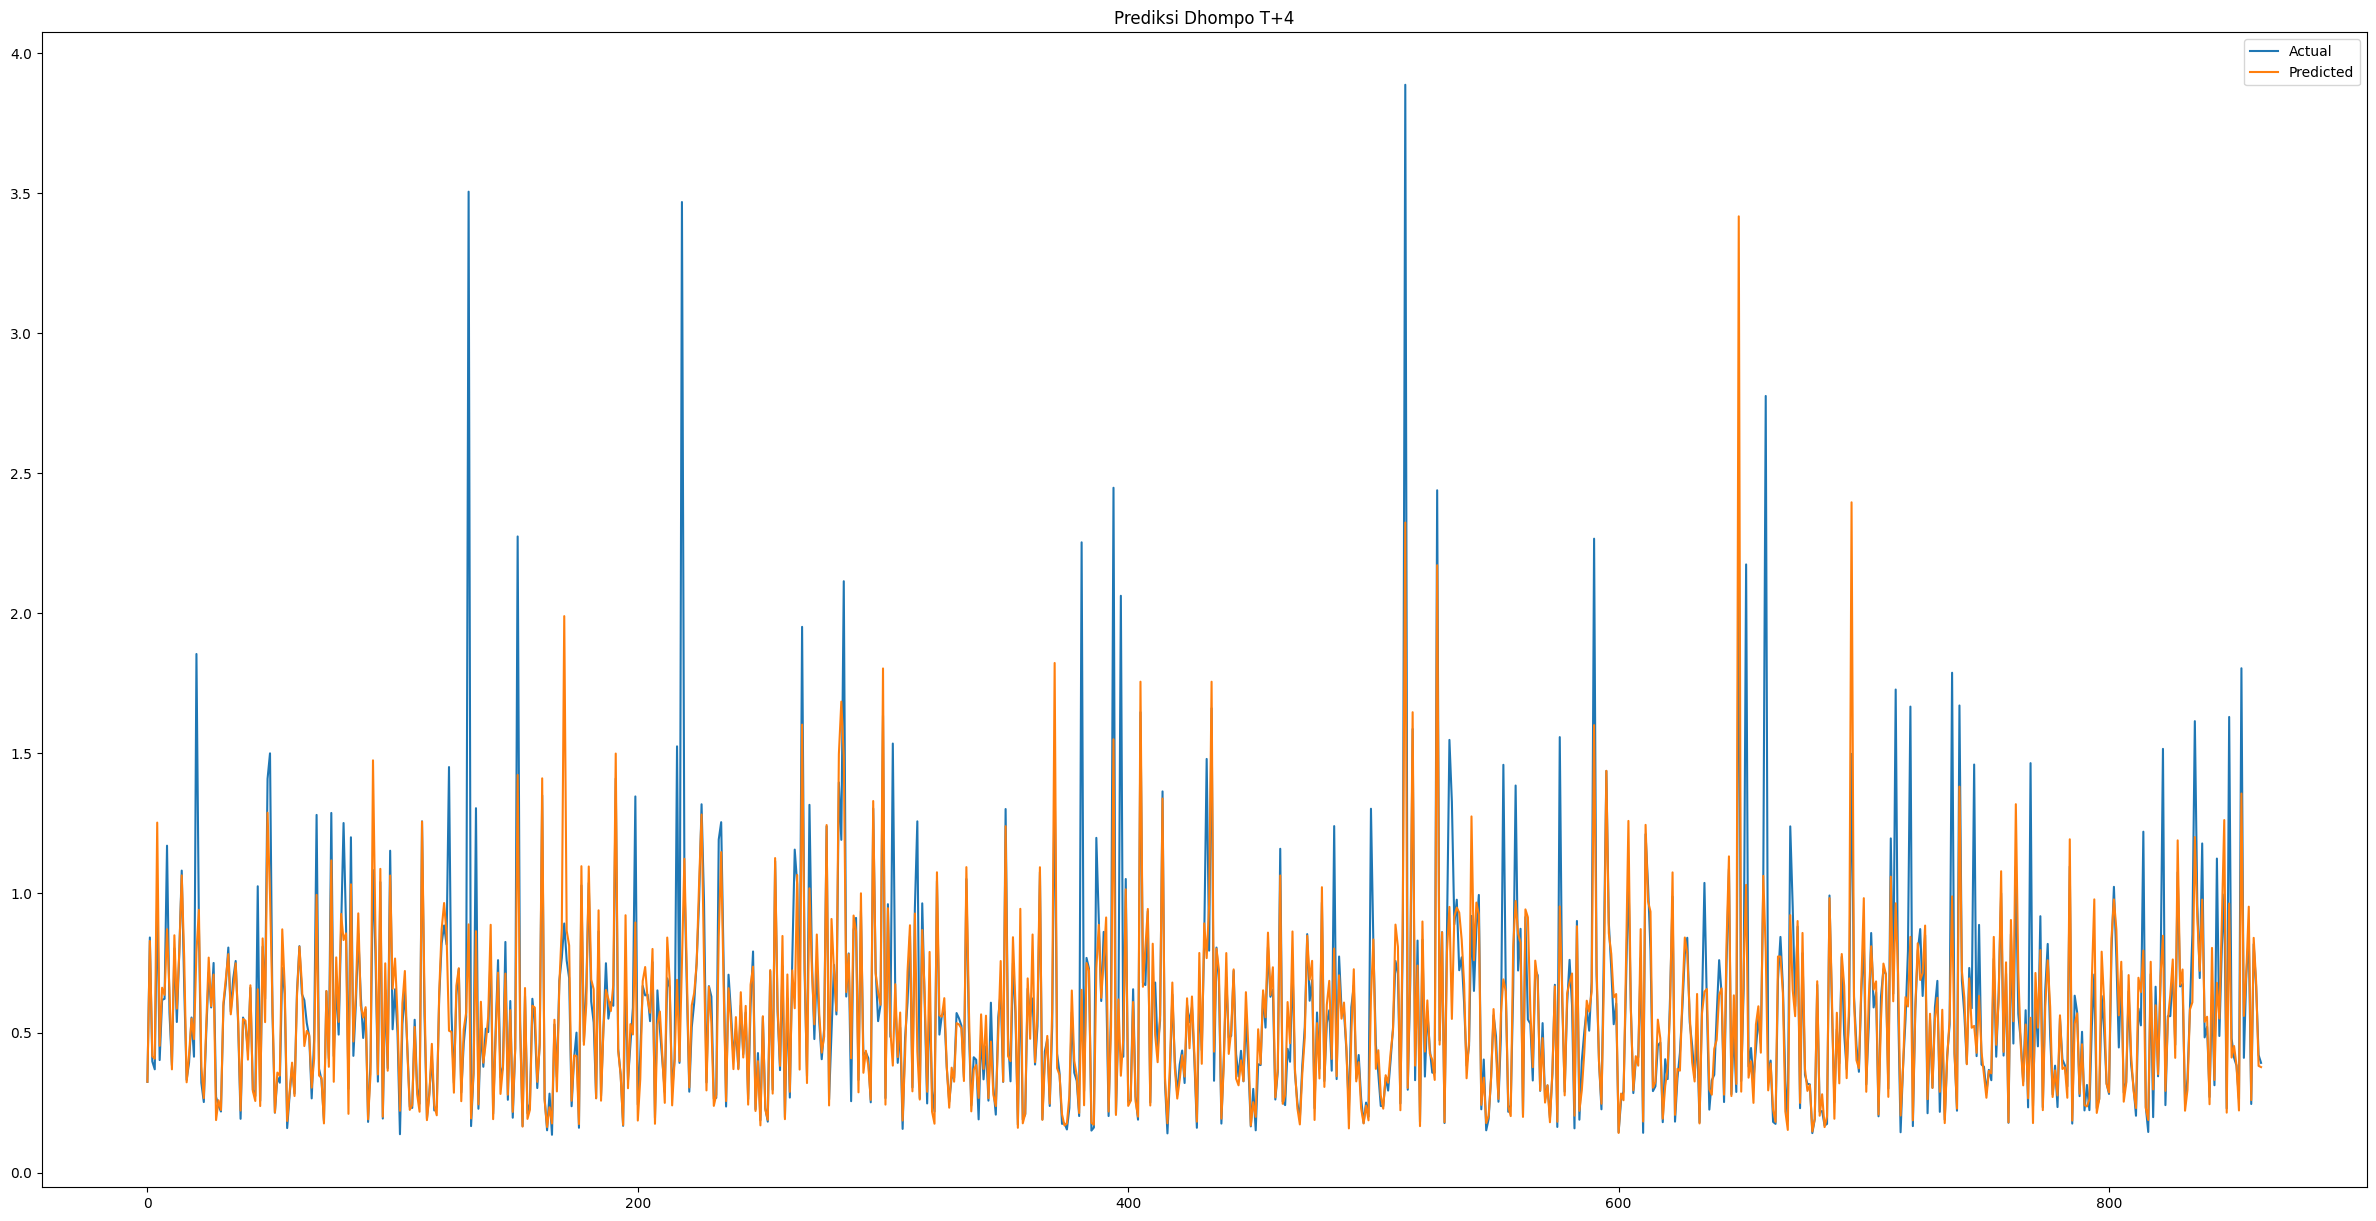

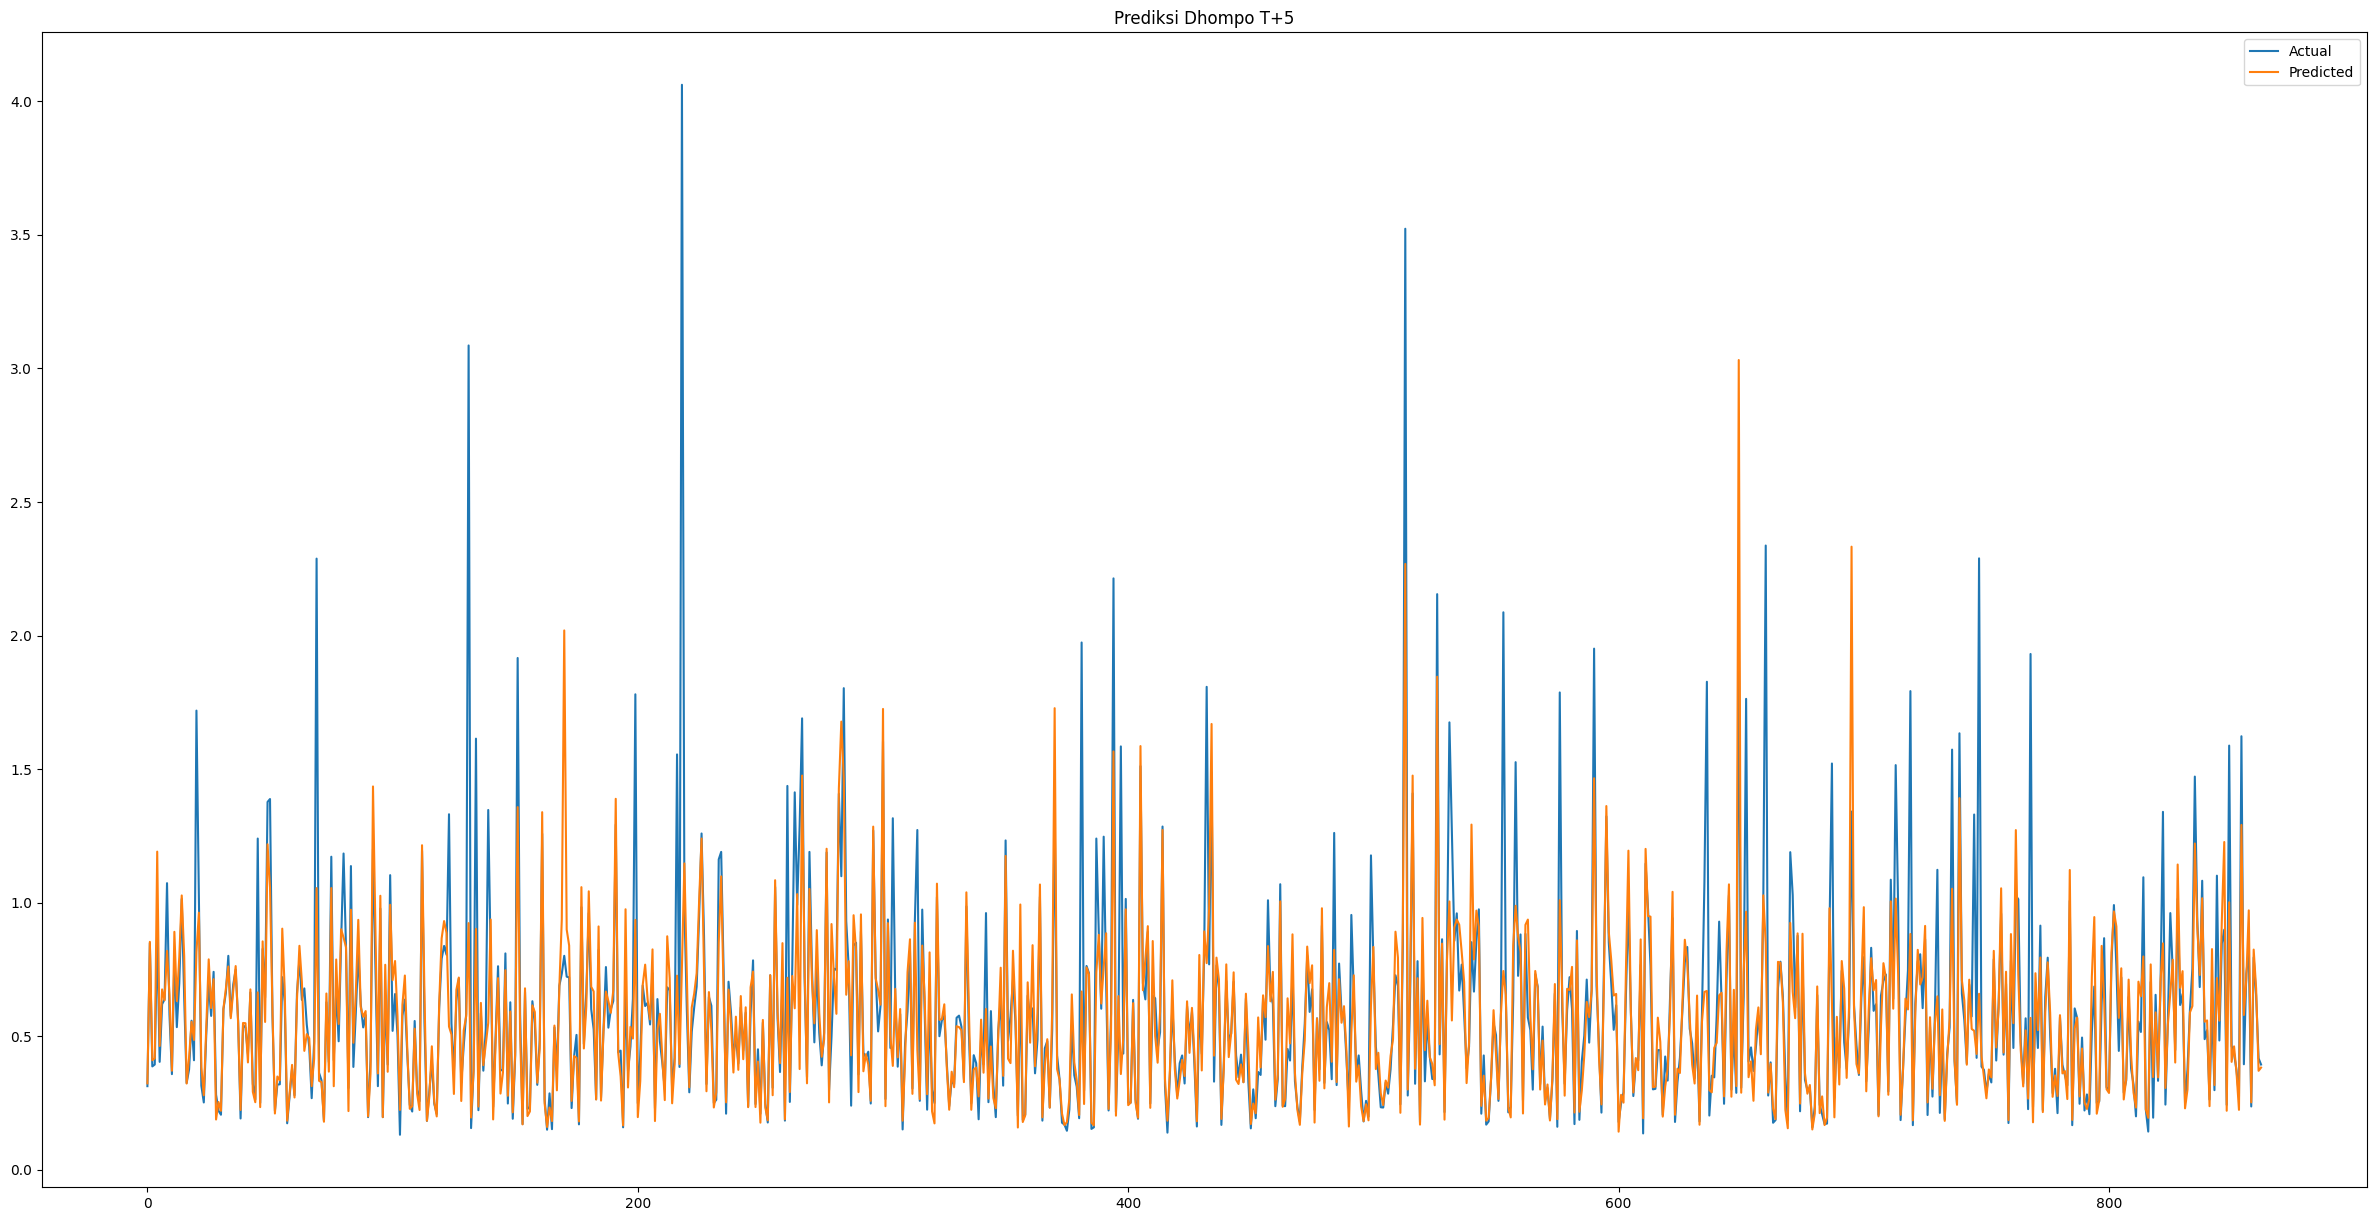

In [39]:
df_final = []
df_final_train = []

for i in range(1, n_steps_out+1):
    df_final.append(pd.DataFrame())
    df_final_train.append(pd.DataFrame())

for i in range(0,n_steps_out):
    df_final[i]['Tinggi Muka Air Dhompo'] = real[i]
    df_final[i]['Prediksi Tinggi Muka Air Dhompo'] = predictions[i]
    df_final_train[i]['Tinggi Muka Air Dhompo'] = real_train[i]
    df_final_train[i]['Prediksi Tinggi Muka Air Dhompo'] = predictions_for_train[i]

    mpl.rcParams['figure.figsize'] = (30, 15)
    mpl.rcParams['axes.grid'] = False
    ax = df_final[i][['Tinggi Muka Air Dhompo', 'Prediksi Tinggi Muka Air Dhompo']].plot()
    ax.legend(["Actual", "Predicted"]) 
    ax.set_title(f"Prediksi Dhompo T+{i+1}")

    plt.show()

# Plot Model Train Dataset

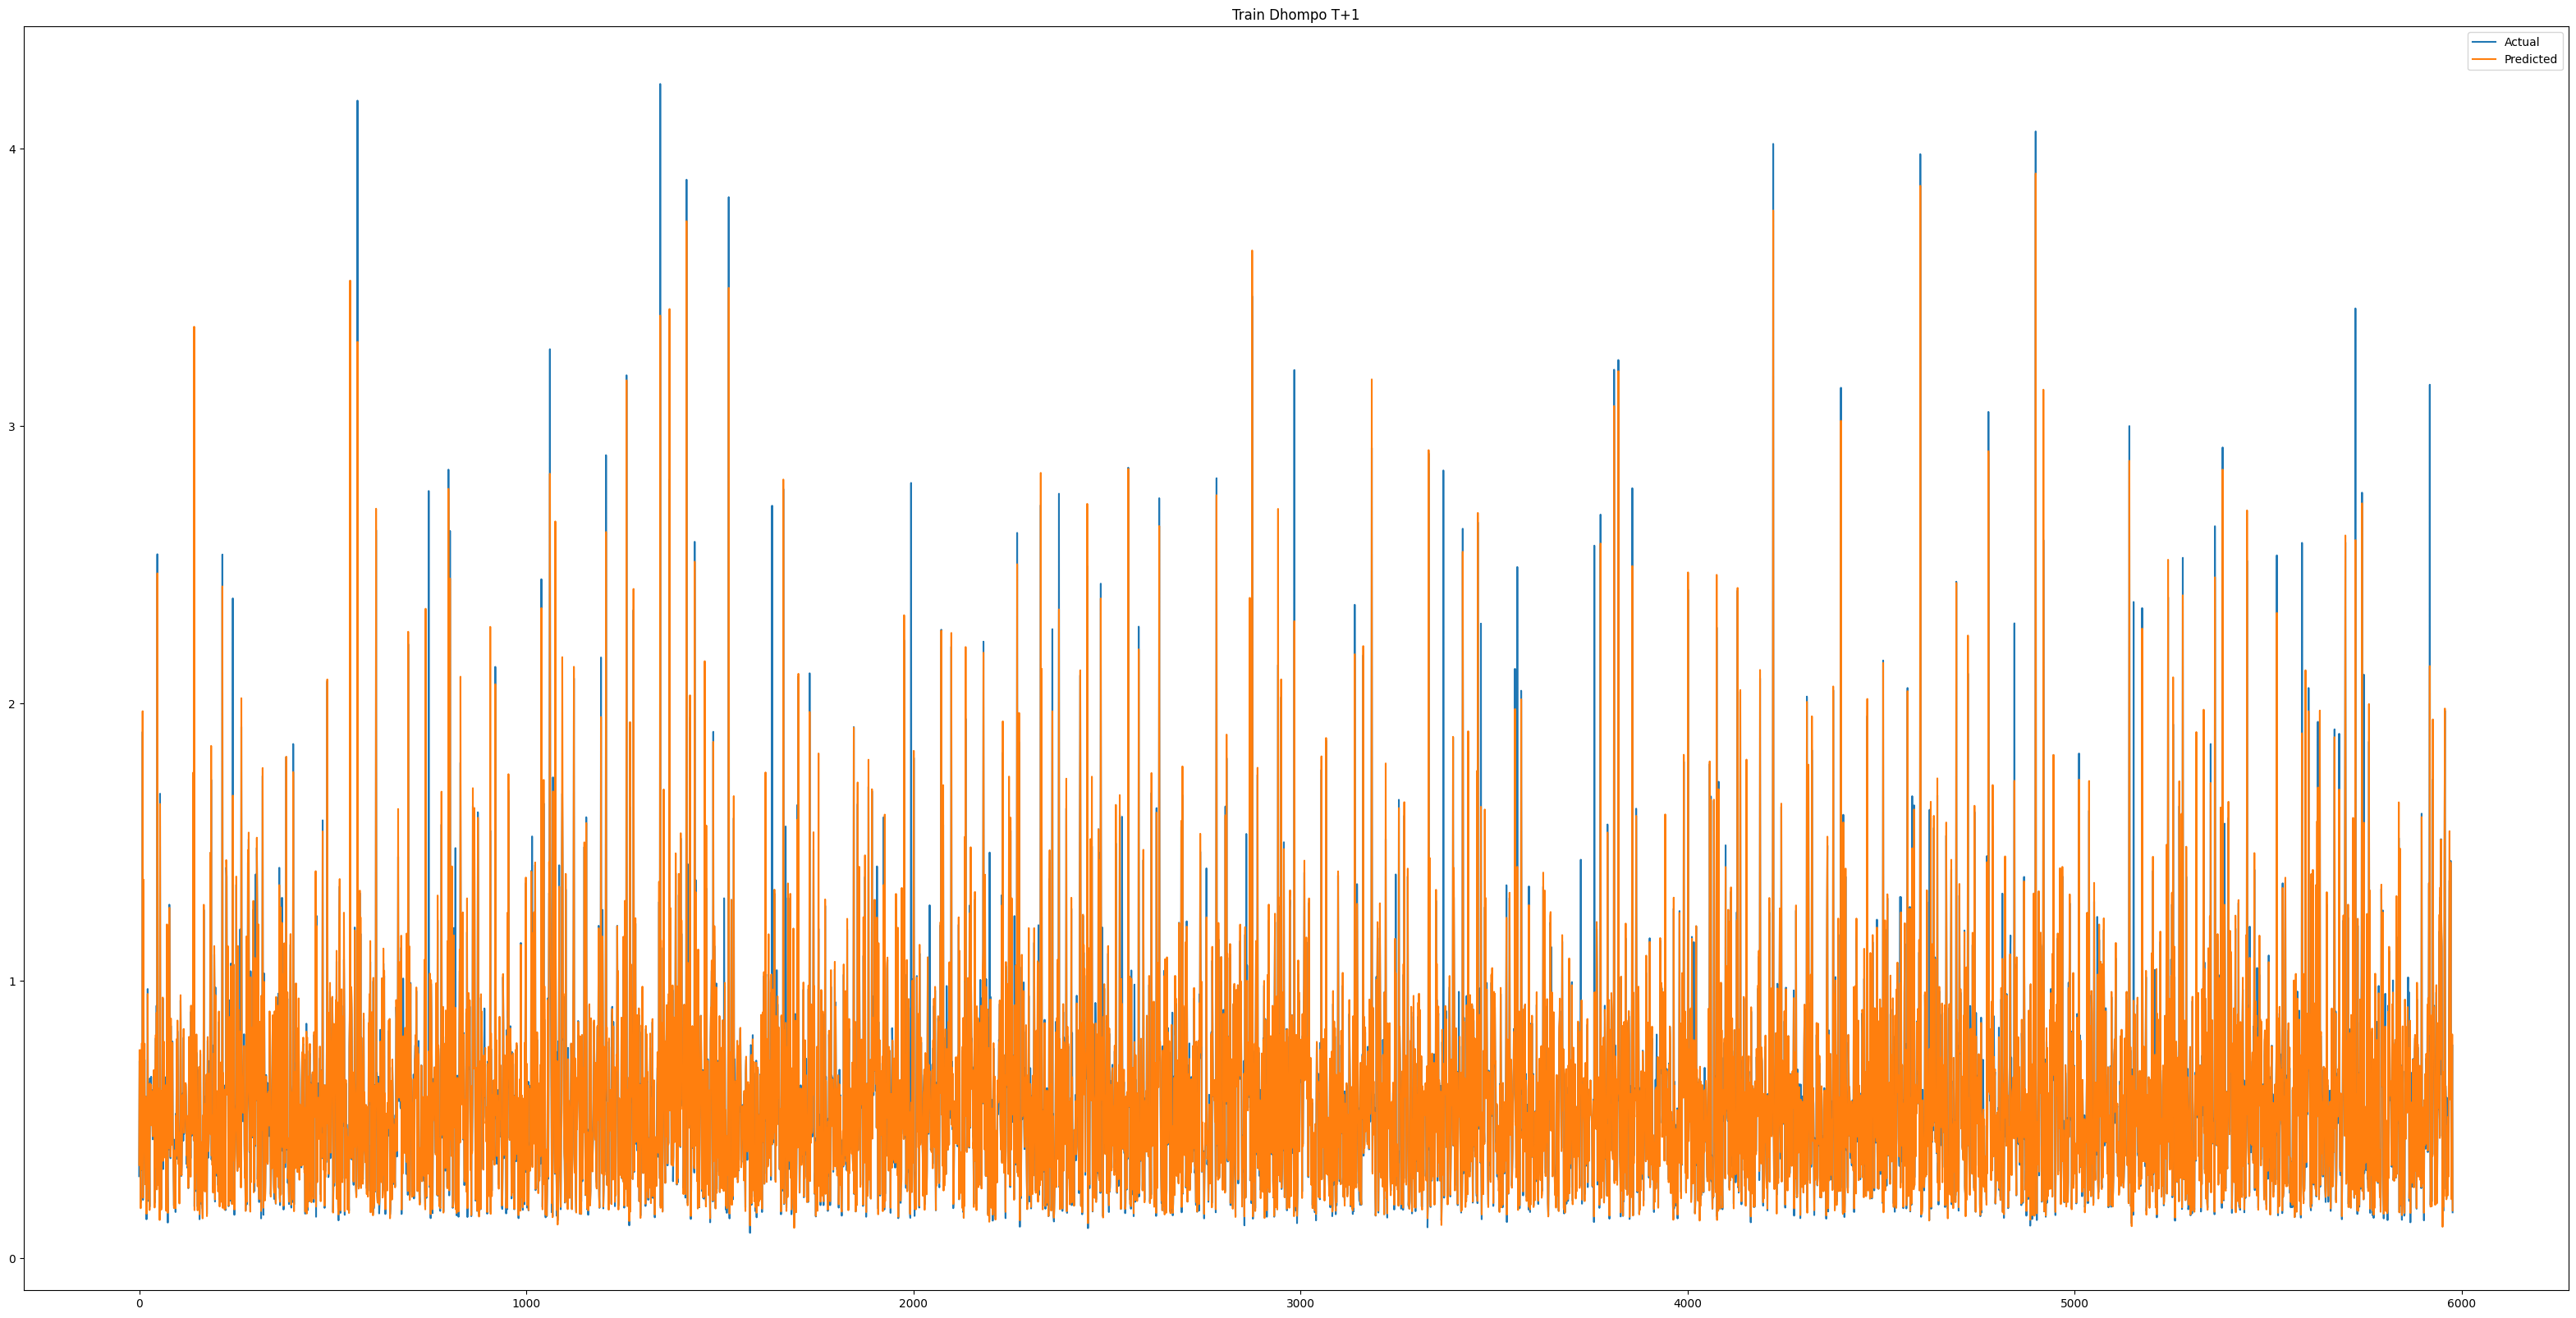

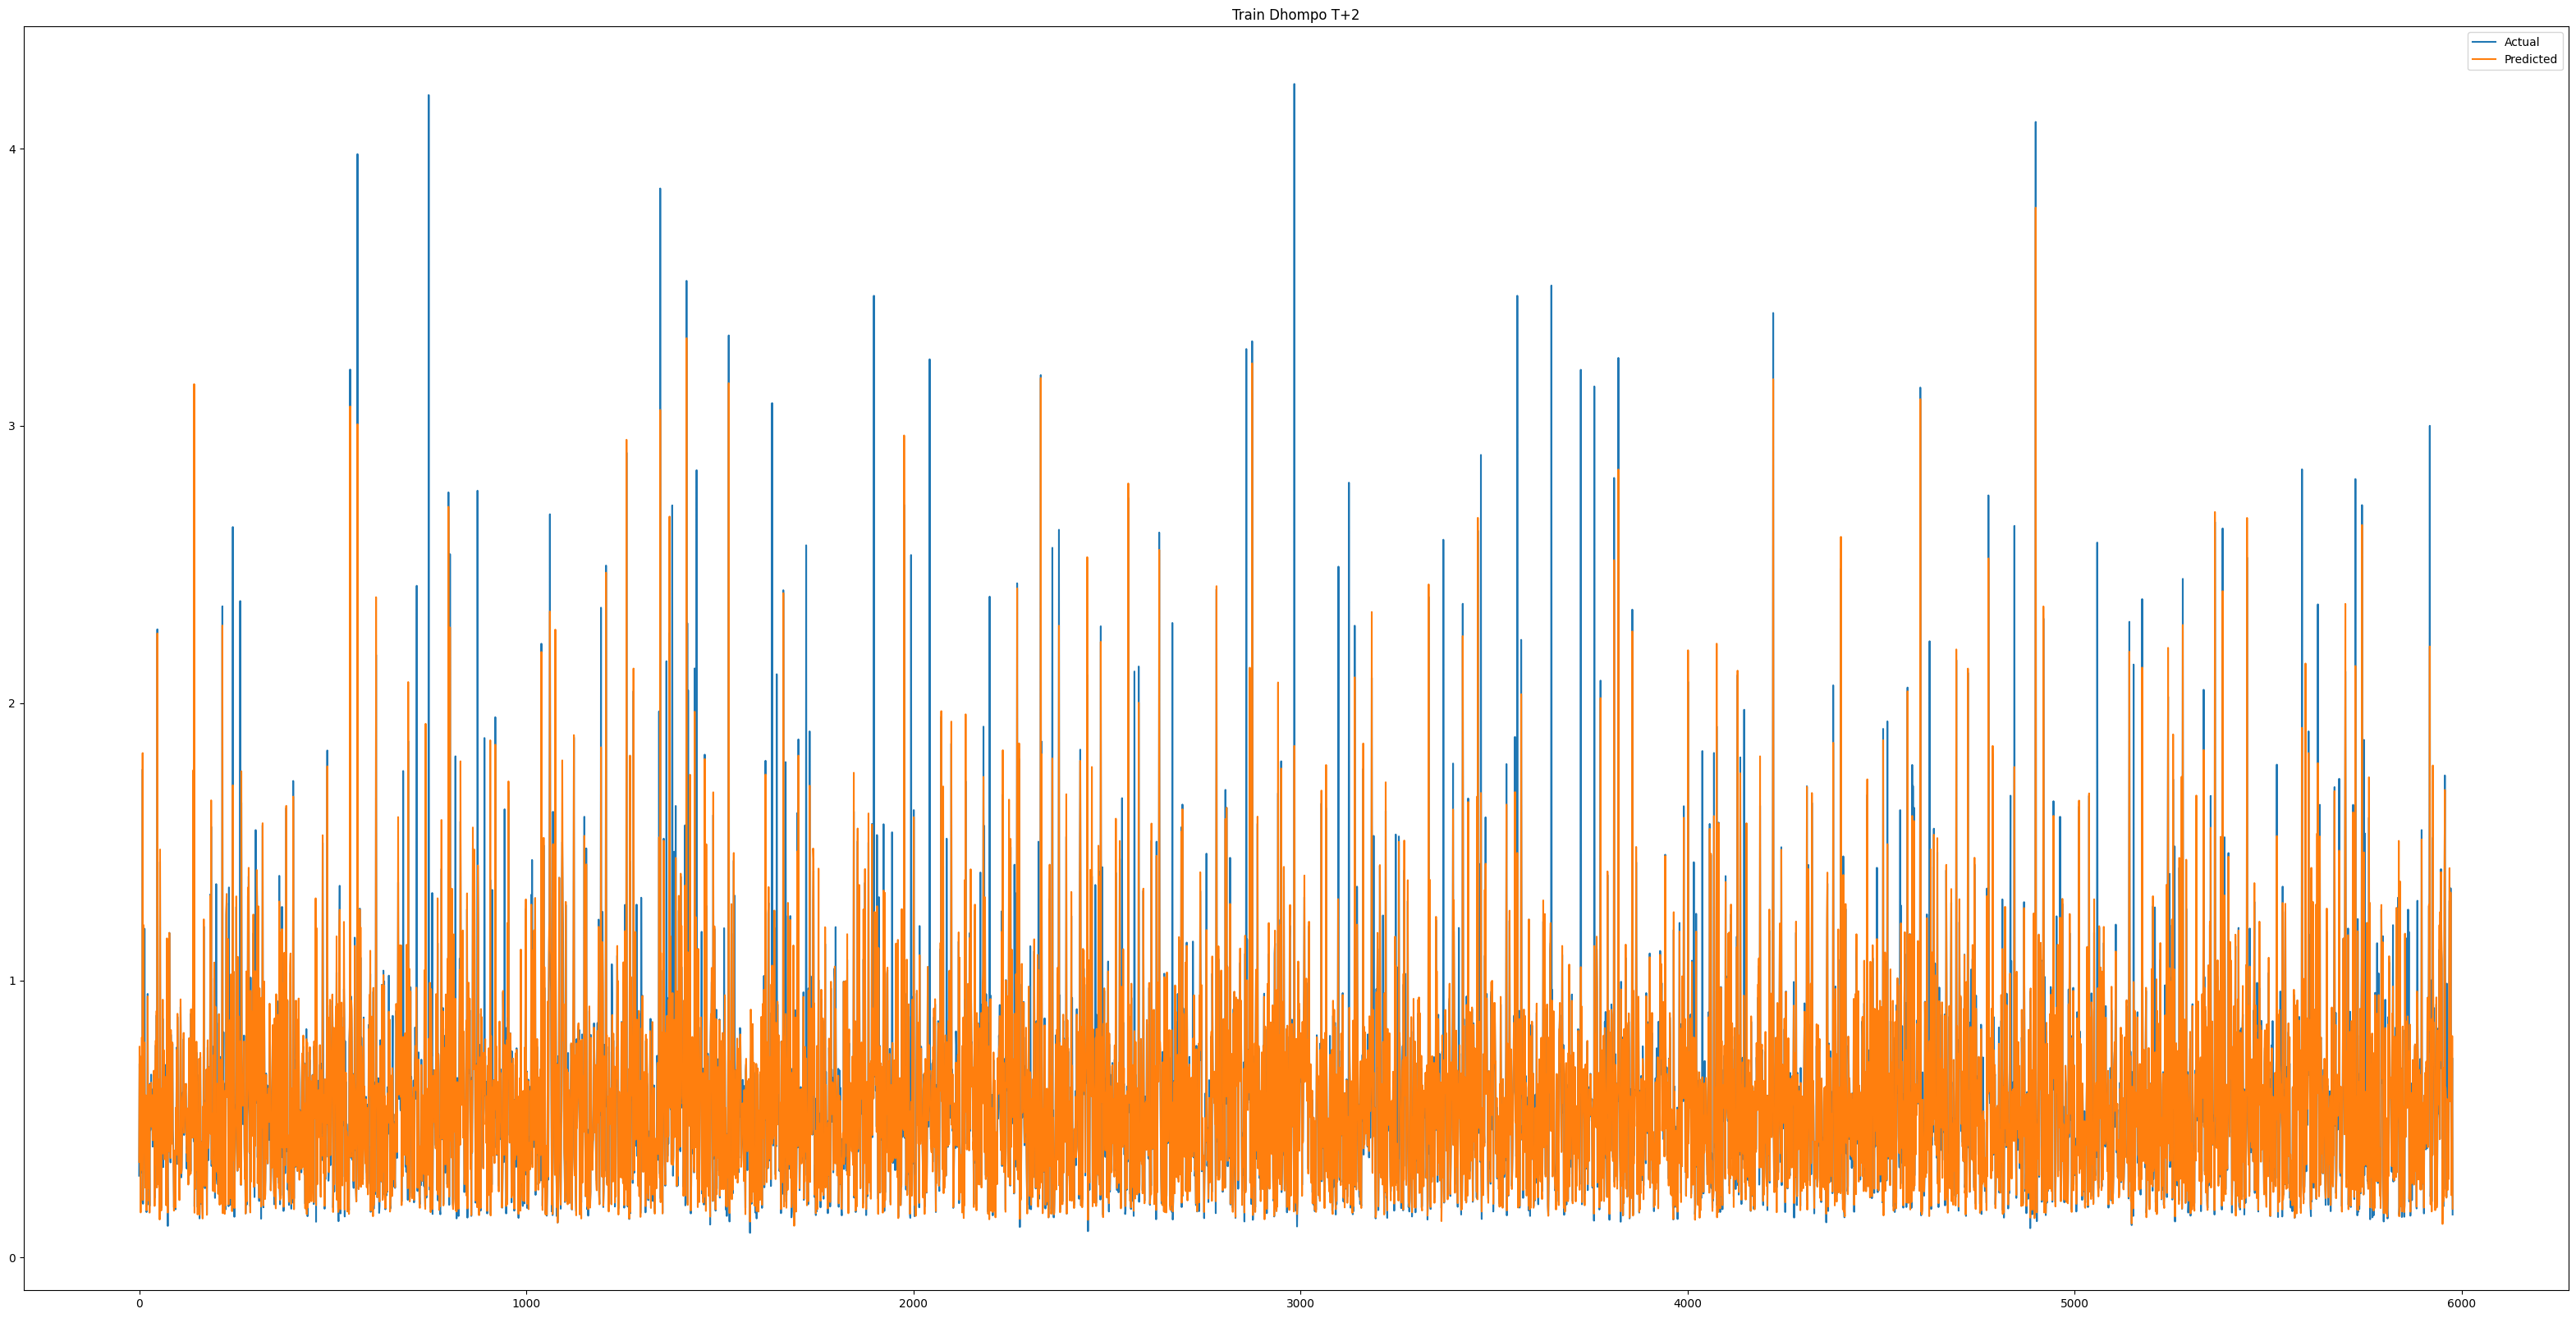

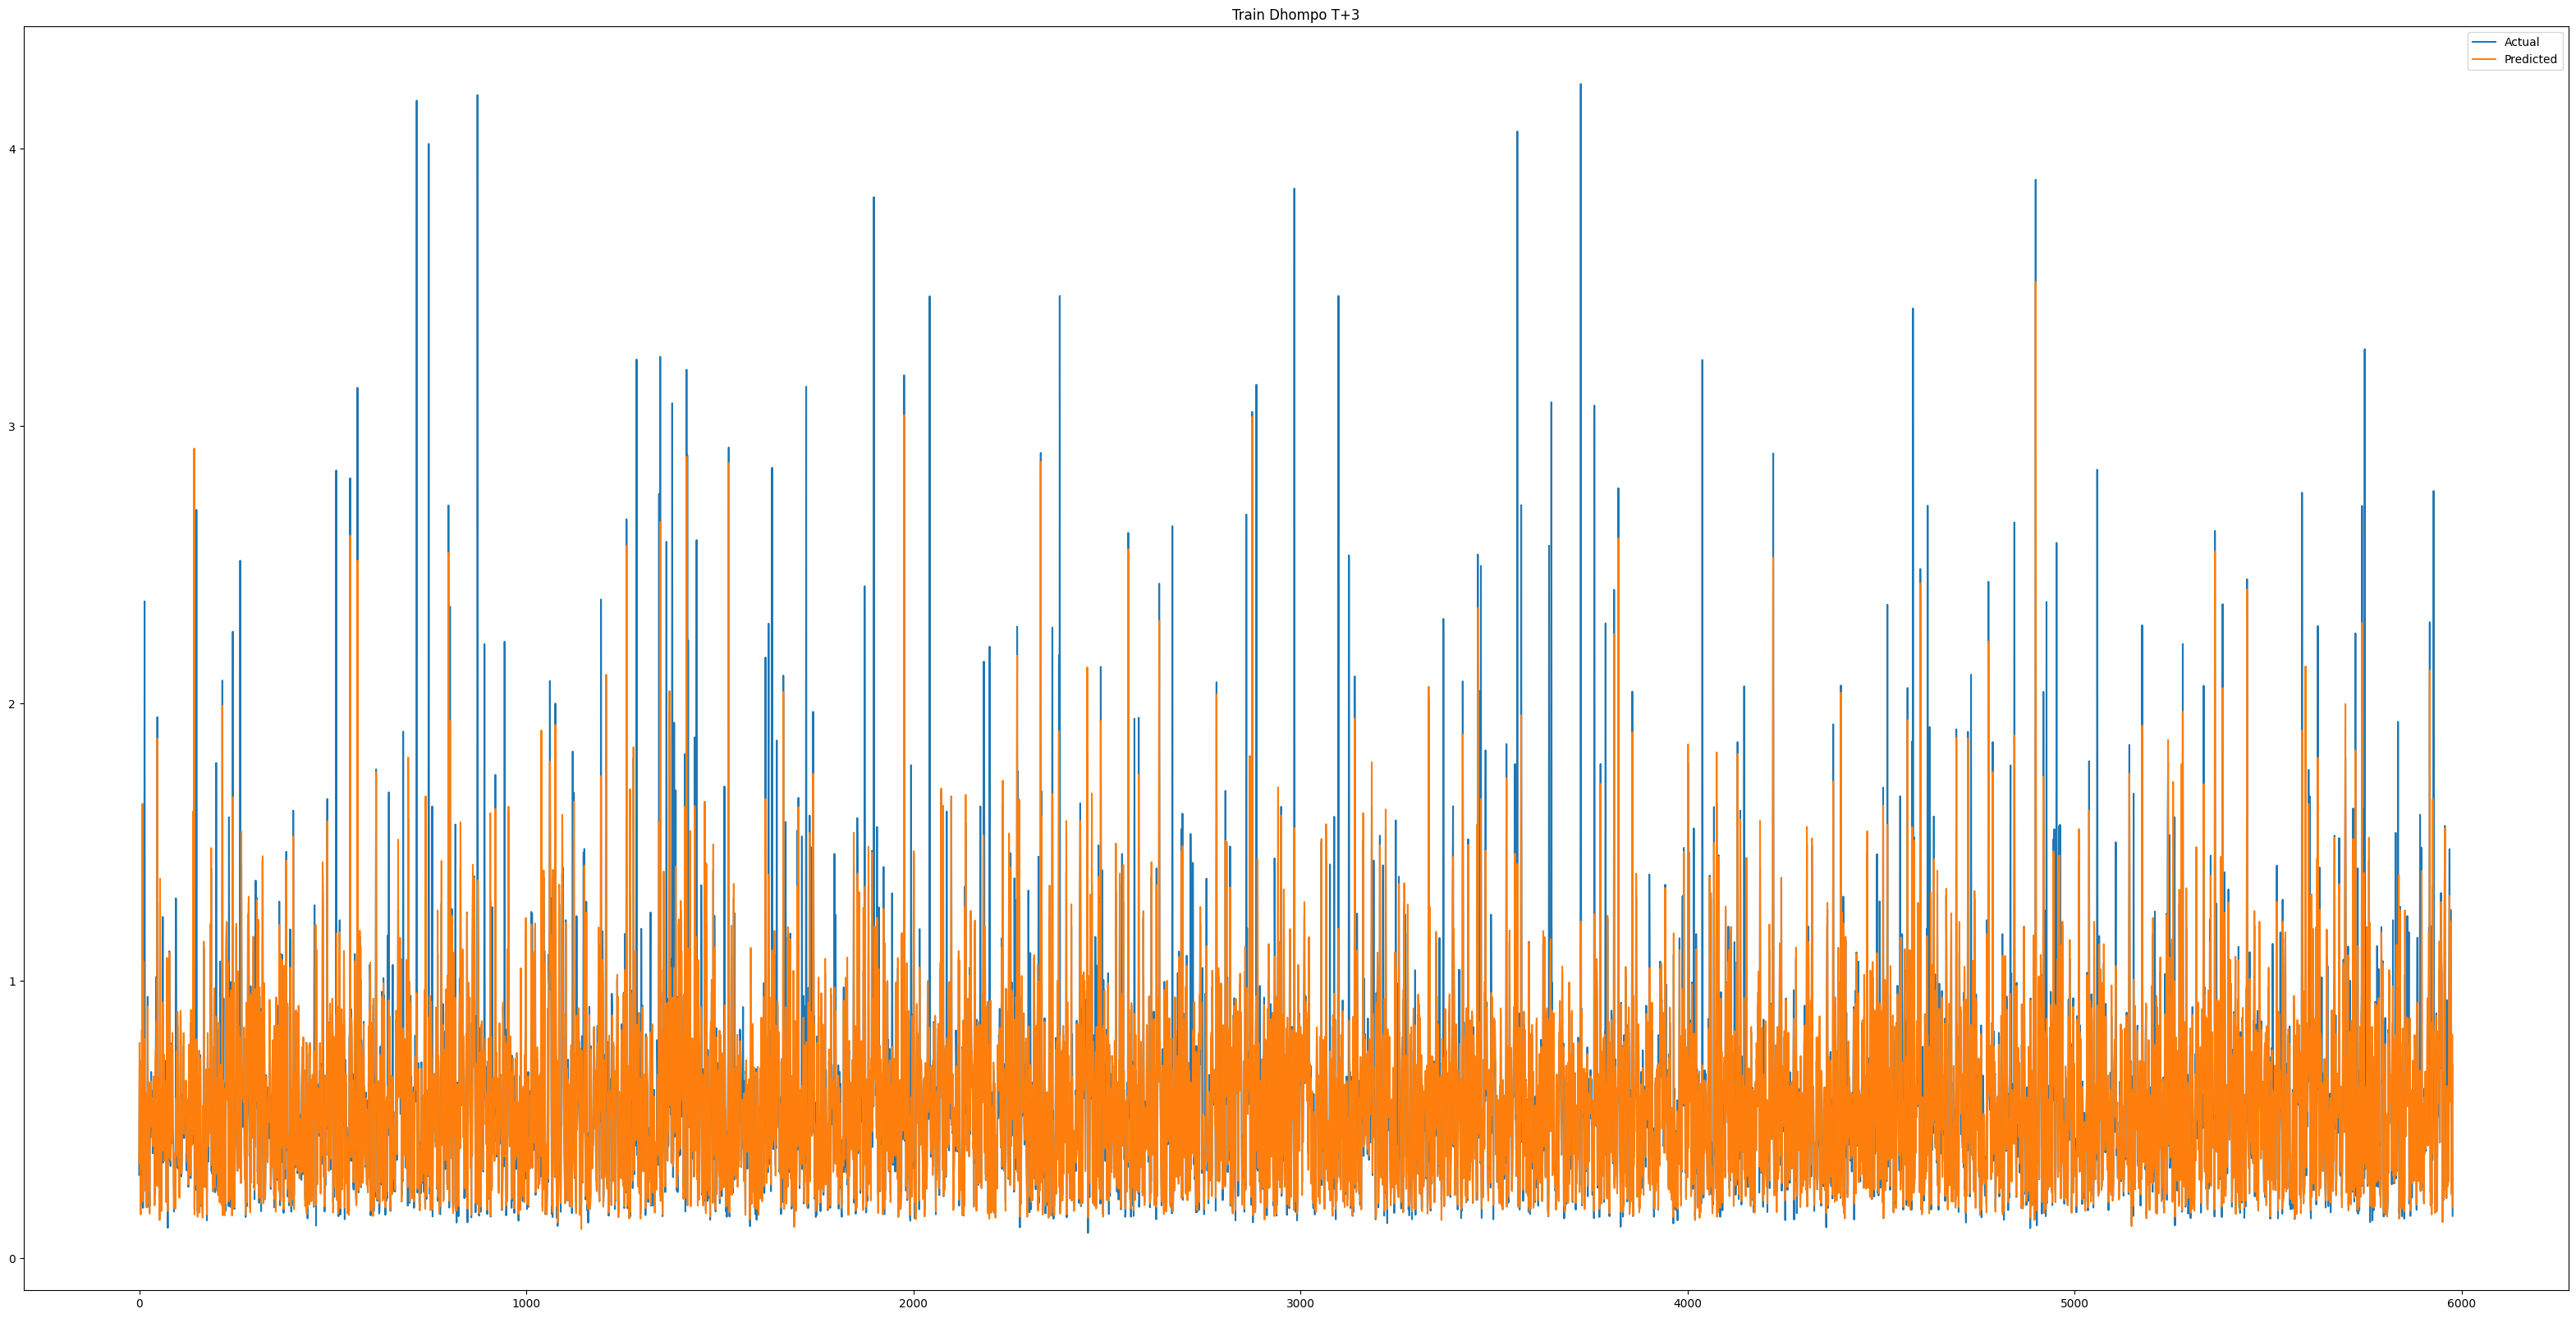

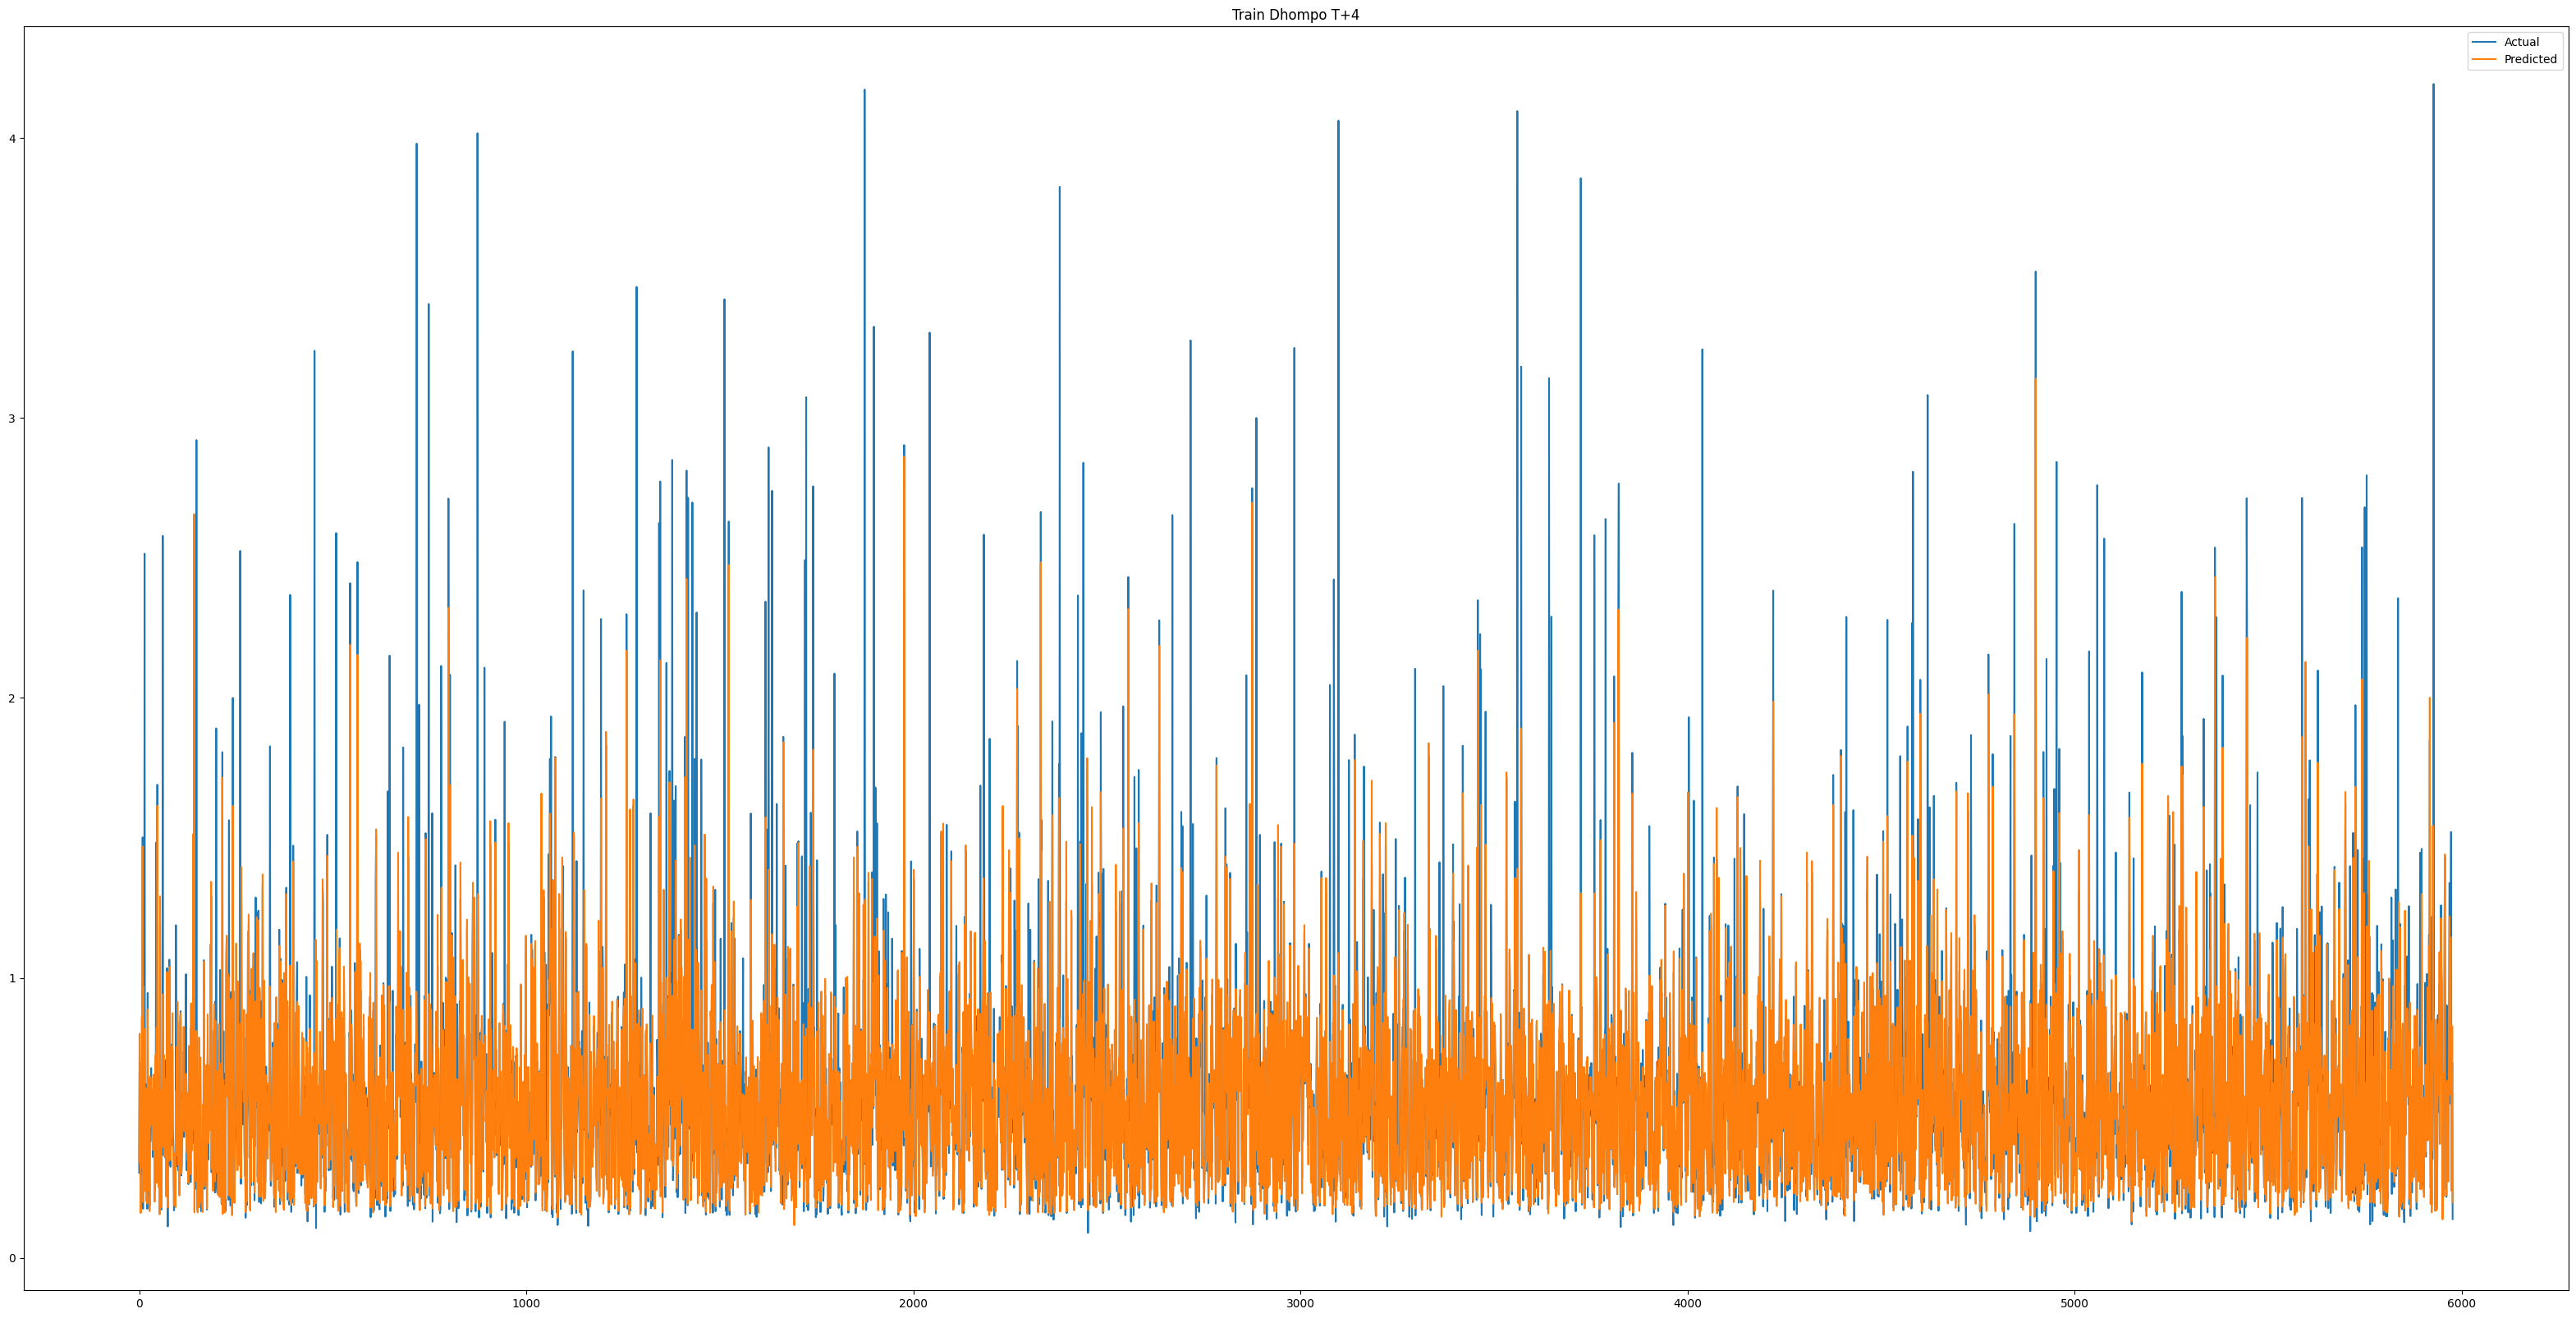

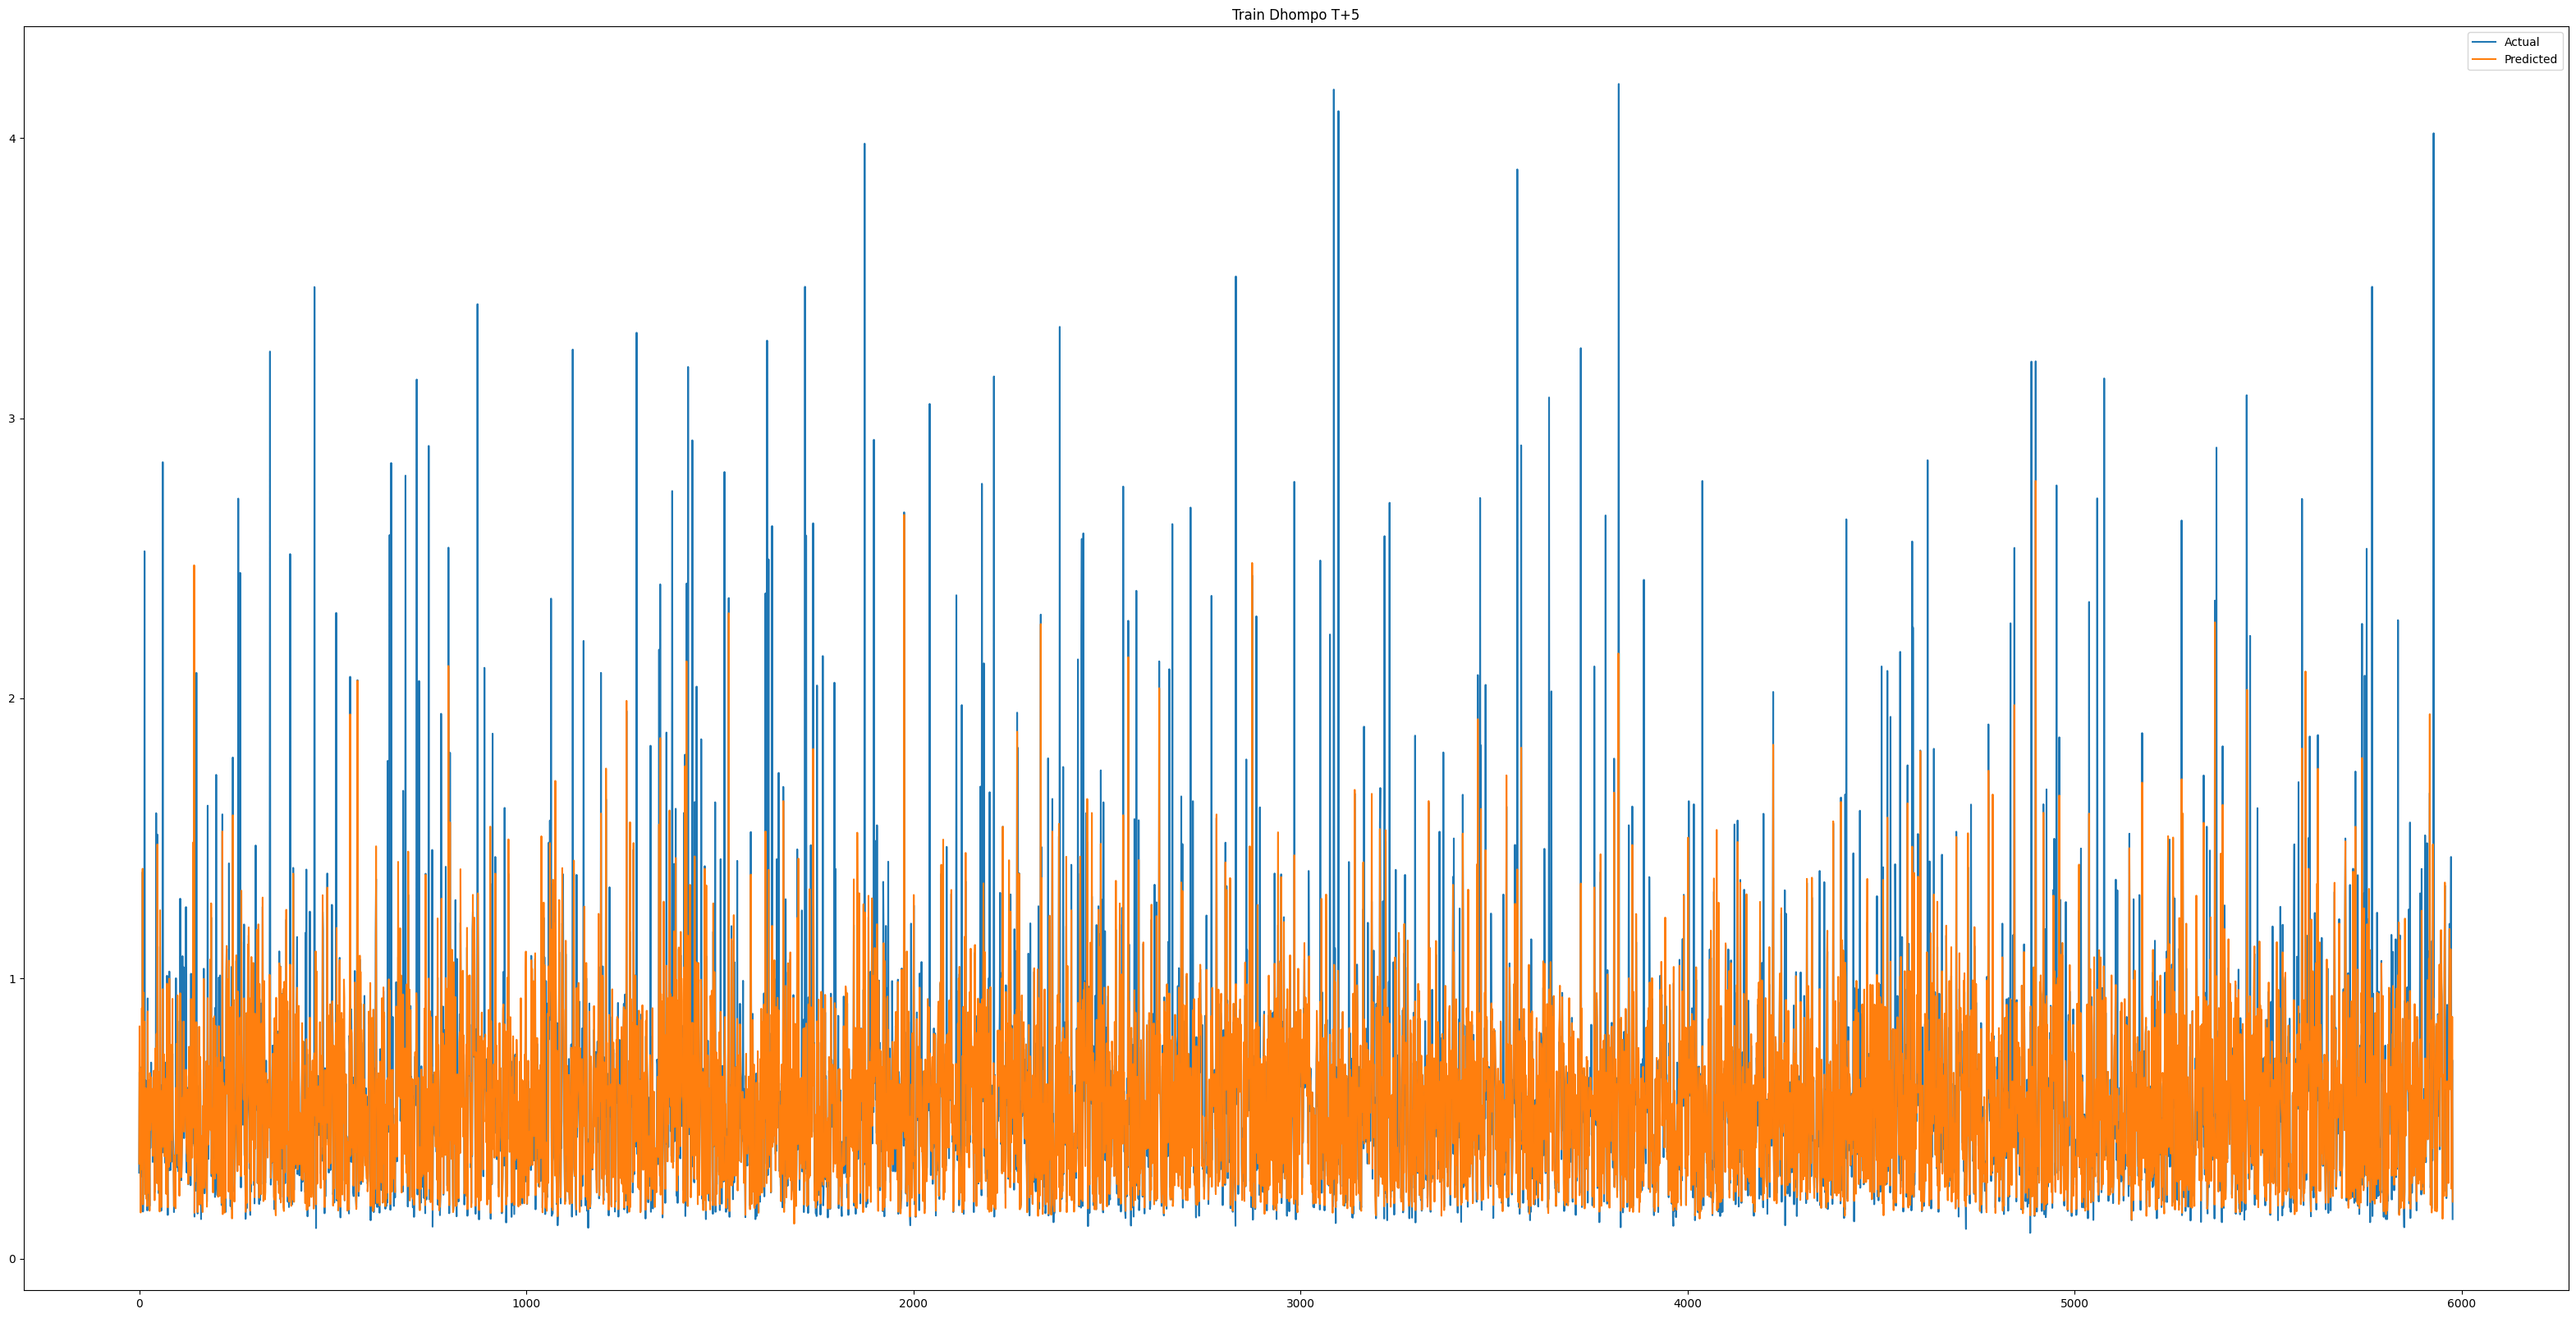

In [40]:
for i in range(0,n_steps_out):
    mpl.rcParams['figure.figsize'] = (40,20)
    mpl.rcParams['axes.grid'] = False
    ax = df_final_train[i][['Tinggi Muka Air Dhompo', 'Prediksi Tinggi Muka Air Dhompo']].plot()
    ax.legend(["Actual", "Predicted"]) 
    ax.set_title(f"Train Dhompo T+{i+1}")

# Evaluation Score

In [41]:
rmse_scores = []
model_names = []
mse_scores = []
mape_scores = []
mae_scores = []

In [42]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_percentage_error

indicator = ['Tinggi Muka Air Dhompo']

for j in range(0,n_steps_out): 
  for i in indicator:
    rmse_scores.append(mean_squared_error(df_final[j][f'{i}'],df_final[j][f'Prediksi {i}'], squared=False))
    mse_scores.append(mean_squared_error(df_final[j][f'{i}'],df_final[j][f'Prediksi {i}']))
    mae_scores.append(mean_absolute_error(df_final[j][f'{i}'], df_final[j][f'Prediksi {i}']))
    mape_scores.append(mean_absolute_percentage_error(df_final[j][f'{i}'], df_final[j][f'Prediksi {i}']))
    model_names.append(f"{i} T+{j+1}")

In [43]:
if all(len(arr) == len(model_names) for arr in [rmse_scores, mse_scores, mae_scores, mape_scores]):
    data = {'Fitur Yang Akan Diprediksi': model_names,
            'RMSE Score Prediction': rmse_scores,
            'MSE Score Prediction': mse_scores,
            'MAE Score Prediction': mae_scores,
            'MAPE Score Prediction': mape_scores}

    df_evaluation = pd.DataFrame(data)
    df_evaluation = df_evaluation.sort_values(by='RMSE Score Prediction', ascending=True)
    pd.set_option('display.float_format', '{:.2f}'.format)
    df_evaluation
else:
    print("Arrays have different lengths.")

In [39]:
df_evaluation

Fitur Yang Akan Diprediksi  RMSE Score Prediction  MSE Score Prediction  \
0  Tinggi Muka Air Dhompo T+1                   0.10                  0.01   
1  Tinggi Muka Air Dhompo T+2                   0.18                  0.03   
2  Tinggi Muka Air Dhompo T+3                   0.21                  0.05   
3  Tinggi Muka Air Dhompo T+4                   0.26                  0.07   
4  Tinggi Muka Air Dhompo T+5                   0.29                  0.08   

   MAE Score Prediction  MAPE Score Prediction  
0                  0.03                   0.05  
1                  0.06                   0.08  
2                  0.08                   0.10  
3                  0.10                   0.12  
4                  0.11                   0.14

In [44]:
df_evaluation

Fitur Yang Akan Diprediksi  RMSE Score Prediction  MSE Score Prediction  \
0  Tinggi Muka Air Dhompo T+1                   0.11                  0.01   
1  Tinggi Muka Air Dhompo T+2                   0.20                  0.04   
2  Tinggi Muka Air Dhompo T+3                   0.22                  0.05   
3  Tinggi Muka Air Dhompo T+4                   0.25                  0.06   
4  Tinggi Muka Air Dhompo T+5                   0.26                  0.07   

   MAE Score Prediction  MAPE Score Prediction  
0                  0.04                   0.05  
1                  0.06                   0.08  
2                  0.08                   0.10  
3                  0.10                   0.12  
4                  0.11                   0.14

In [43]:
df_evaluation.to_excel('Dhompo_GRU_Predict_T+5 using T-3.xlsx')

# Perbandingan Selisih Dalam Angka

In [99]:
for i in range(0,n_steps_out):
    df_final[i] = df_final[i].round(2)
    df_final[i][f"Difference_Rerata Tinggi Muka Air T+{i+1} dan Prediksi Tinggi Muka Air T+{i+1}"] = abs(df_final[i]['Tinggi Muka Air Dhompo'] - df_final[i]['Prediksi Tinggi Muka Air Dhompo'])

In [100]:
df_final[0]

Fitur Yang Akan Diprediksi  RMSE Score Prediction  MSE Score Prediction  \
0  Tinggi Muka Air Dhompo T+1                   0.15                  0.02   
1  Tinggi Muka Air Dhompo T+2                   0.22                  0.05   
2  Tinggi Muka Air Dhompo T+3                   0.25                  0.06   
3  Tinggi Muka Air Dhompo T+4                   0.26                  0.07   
4  Tinggi Muka Air Dhompo T+5                   0.31                  0.10   

   MAE Score Prediction  MAPE Score Prediction  
0                  0.05                   0.05  
1                  0.07                   0.09  
2                  0.09                   0.11  
3                  0.11                   0.14  
4                  0.13                   0.15

# Save Model

In [43]:
model.save_weights('./checkpoints/my_checkpoint')

In [44]:
!mkdir -p saved_model
model.save('saved_model/dhompo_gru')
model.save('dhompo_gru.h5')

INFO:tensorflow:Assets written to: saved_model/dhompo_gru/assets


INFO:tensorflow:Assets written to: saved_model/dhompo_gru/assets


In [45]:
import pickle
with open('dhompo_gru_x_scaler.pkl', 'wb') as file:
    pickle.dump(x_scaler, file)
    
with open('dhompo_gru_y_scaler.pkl', 'wb') as file:
    pickle.dump(y_scaler, file)